In [ ]:
!rm -rf sample_data/ #extra space freeing

In [ ]:
!unzip SCUT_FBP5500_downsampled.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/3_AM653.jpg        
  inflating: test/3_AM666.jpg        
  inflating: test/3_AM682.jpg        
  inflating: test/3_AM702.jpg        
  inflating: test/3_AM716.jpg        
  inflating: test/3_AM741.jpg        
  inflating: test/3_AM751.jpg        
  inflating: test/3_AM767.jpg        
  inflating: test/3_AM780.jpg        
  inflating: test/3_AM794.jpg        
  inflating: test/3_AM810.jpg        
  inflating: test/3_AM827.jpg        
  inflating: test/3_AM837.jpg        
  inflating: test/3_AM848.jpg        
  inflating: test/3_AM865.jpg        
  inflating: test/3_AM884.jpg        
  inflating: test/3_AM899.jpg        
  inflating: test/3_AM909.jpg        
  inflating: test/3_AM919.jpg        
  inflating: test/3_AM933.jpg        
  inflating: test/3_AM954.jpg        
  inflating: test/3_AM978.jpg        
  inflating: test/3_AM989.jpg        
  inflating: test/3_AM998.jpg        
  inflating: test/3_CF115.jpg        

# Seeding For reproducability

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_global_seed(seed=42):
    # 1. Python built-in RNG
    random.seed(seed)

    # 2. NumPy RNG
    np.random.seed(seed)

    # 3. TensorFlow RNG
    tf.random.set_seed(seed)

    # 4. (Optional) CUDA / cuDNN determinism
    os.environ["TF_DETERMINISTIC_OPS"] = "1"   # makes conv/pool deterministic
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    print(f"✅ Global seed set to {seed}")

# Call this once, at the top of your notebook / main.py
set_global_seed(1234)

✅ Global seed set to 1234


# Dataset Loading

In [ ]:
import tensorflow as tf

# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf
import os

def parse_label_from_path(path):
    fname = tf.strings.regex_replace(path, r".*[\\/]", "")          # -> b"7_CM668.jpg"
    # 2) grab the leading integer before the underscore
    num   = tf.strings.regex_replace(fname, r"^([0-9]+)_.*$", r"\1")# -> b"7"
    # 3) to float and shape (1,) for regression
    label = tf.strings.to_number(num, out_type=tf.float32)
    return tf.reshape(label, [1])  # regression target shape [1]

def process_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (80, 80)) / 255.0
    y = parse_label_from_path(path)
    return img, y  # <-- (features, label)

train_dataset = (tf.data.Dataset.list_files("training/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = (tf.data.Dataset.list_files("validation/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Checking the dataset whether it is correct

In [ ]:
import tensorflow as tf

print("train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("val cardinality  :", tf.data.experimental.cardinality(validation_dataset))

for xb, yb in train_dataset.batch(32).take(1):
    print("first train batch:", xb.shape, yb.shape)
for xb, yb in train_dataset.batch(32).skip(111).take(1):  # last step
    print("last  train batch:", xb.shape, yb.shape)       # expect (3, 80, 80, 3)

train cardinality: tf.Tensor(3555, shape=(), dtype=int64)
val cardinality  : tf.Tensor(893, shape=(), dtype=int64)
first train batch: (32, 80, 80, 3) (32, 1)
last  train batch: (3, 80, 80, 3) (3, 1)


In [ ]:
%ls training | wc -l
%ls validation | wc -l
!nproc

3555
893
12


Sample numbers are correct for training validation
Input image dimensions are correct B,H,W,C and 1 dimension for

In [ ]:
def dataset_stats(ds, batch_size=32):
    """
    Computes min, max, mean, std for images and labels.
    - Assumes each element is (image, label) with image float in [0,1] and label shape (1,) or ().
    - Returns dict with global image stats (over all pixels) and per-channel stats,
      and label stats (over samples).
    """
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Global image stats (all pixels), and per-channel stats
    img_min = tf.constant(float('inf'), tf.float32)
    img_max = tf.constant(float('-inf'), tf.float32)
    img_sum = tf.constant(0.0, tf.float32)
    img_sumsq = tf.constant(0.0, tf.float32)
    img_count = tf.constant(0.0, tf.float32)

    ch_sum = None
    ch_sumsq = None
    ch_count = None

    # Label stats (per sample)
    y_min = tf.constant(float('inf'), tf.float32)
    y_max = tf.constant(float('-inf'), tf.float32)
    y_sum = tf.constant(0.0, tf.float32)
    y_sumsq = tf.constant(0.0, tf.float32)
    y_count = tf.constant(0.0, tf.float32)

    for xb, yb in ds:
        # Ensure float32
        xb = tf.cast(xb, tf.float32)
        yb = tf.cast(yb, tf.float32)

        # ----- images: global -----
        img_min = tf.minimum(img_min, tf.reduce_min(xb))
        img_max = tf.maximum(img_max, tf.reduce_max(xb))
        img_sum += tf.reduce_sum(xb)
        img_sumsq += tf.reduce_sum(tf.square(xb))
        img_count += tf.cast(tf.size(xb), tf.float32)

        # ----- images: per-channel -----
        # reduce over N, H, W; keep C
        ch_axes = [0, 1, 2]  # assuming NHWC
        cur_ch_sum = tf.reduce_sum(xb, axis=ch_axes)         # shape (C,)
        cur_ch_sumsq = tf.reduce_sum(tf.square(xb), axis=ch_axes)  # (C,)
        cur_ch_count = tf.cast(tf.reduce_prod(tf.shape(xb)[:3]), tf.float32)  # N*H*W
        if ch_sum is None:
            ch_sum = cur_ch_sum
            ch_sumsq = cur_ch_sumsq
            ch_count = cur_ch_count
        else:
            ch_sum += cur_ch_sum
            ch_sumsq += cur_ch_sumsq
            ch_count += cur_ch_count

        # ----- labels -----
        y_min = tf.minimum(y_min, tf.reduce_min(yb))
        y_max = tf.maximum(y_max, tf.reduce_max(yb))
        y_sum += tf.reduce_sum(yb)
        y_sumsq += tf.reduce_sum(tf.square(yb))
        y_count += tf.cast(tf.size(yb), tf.float32)  # count of label scalars

    # finalize
    img_mean = img_sum / tf.maximum(img_count, 1.0)
    img_var = tf.maximum(img_sumsq / tf.maximum(img_count, 1.0) - tf.square(img_mean), 0.0)
    img_std = tf.sqrt(img_var)

    ch_mean = ch_sum / tf.maximum(ch_count, 1.0) if ch_sum is not None else None
    ch_var = tf.maximum(ch_sumsq / tf.maximum(ch_count, 1.0) - tf.square(ch_mean), 0.0) if ch_sum is not None else None
    ch_std = tf.sqrt(ch_var) if ch_var is not None else None

    y_mean = y_sum / tf.maximum(y_count, 1.0)
    y_var = tf.maximum(y_sumsq / tf.maximum(y_count, 1.0) - tf.square(y_mean), 0.0)
    y_std = tf.sqrt(y_var)

    return {
        "image_global": {"min": float(img_min.numpy()),
                         "max": float(img_max.numpy()),
                         "mean": float(img_mean.numpy()),
                         "std":  float(img_std.numpy())},
        "image_per_channel": None if ch_sum is None else {
            "mean": ch_mean.numpy().tolist(),
            "std":  ch_std.numpy().tolist(),
        },
        "labels": {"min": float(y_min.numpy()),
                   "max": float(y_max.numpy()),
                   "mean": float(y_mean.numpy()),
                   "std":  float(y_std.numpy())}
    }

# ---- run on your datasets (unbatched ds expected) ----
train_stats = dataset_stats(train_dataset, batch_size=32)
val_stats   = dataset_stats(validation_dataset, batch_size=32)

print("TRAIN image (global):", train_stats["image_global"])
print("TRAIN image (per-channel RGB):", train_stats["image_per_channel"])
print("TRAIN labels:", train_stats["labels"])

print("VAL image (global):", val_stats["image_global"])
print("VAL image (per-channel RGB):", val_stats["image_per_channel"])
print("VAL labels:", val_stats["labels"])


TRAIN image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.4945290684700012, 'std': 0.29457250237464905}
TRAIN image (per-channel RGB): {'mean': [0.6062124371528625, 0.4732199013233185, 0.4041549861431122], 'std': [0.3239644765853882, 0.2707996964454651, 0.2468571960926056]}
TRAIN labels: {'min': 1.0, 'max': 8.0, 'mean': 4.056540012359619, 'std': 1.9739253520965576}
VAL image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.4917309284210205, 'std': 0.293306440114975}
VAL image (per-channel RGB): {'mean': [0.6028152704238892, 0.4702852964401245, 0.40209218859672546], 'std': [0.321927934885025, 0.2697136104106903, 0.24671496450901031]}
VAL labels: {'min': 1.0, 'max': 8.0, 'mean': 4.053751468658447, 'std': 1.975612759590149}


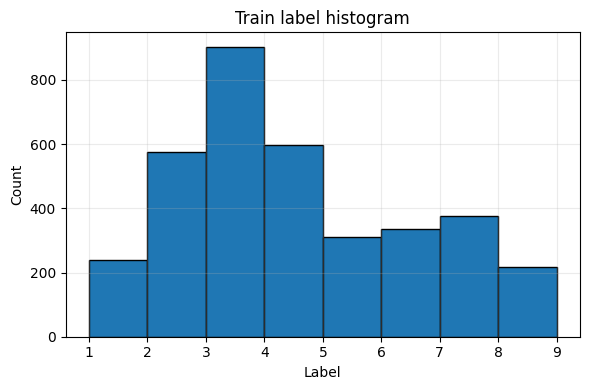

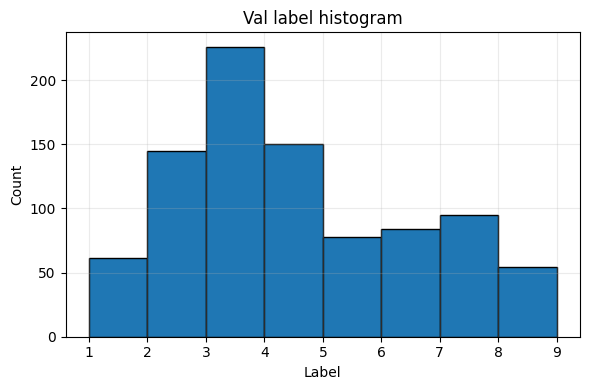

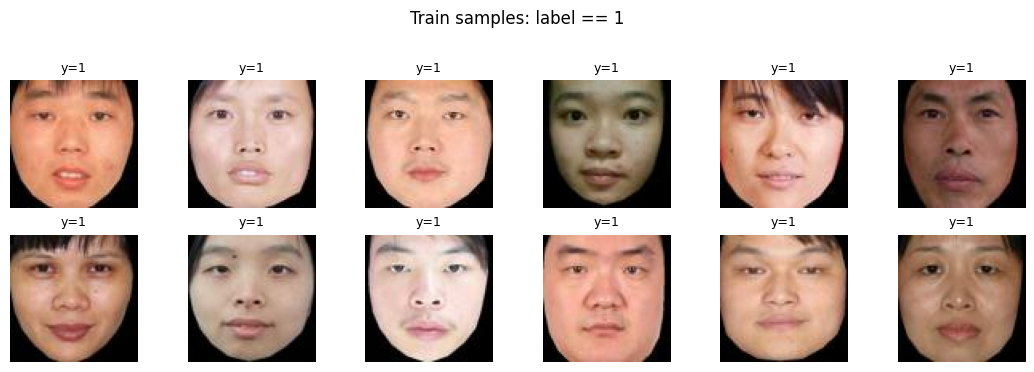

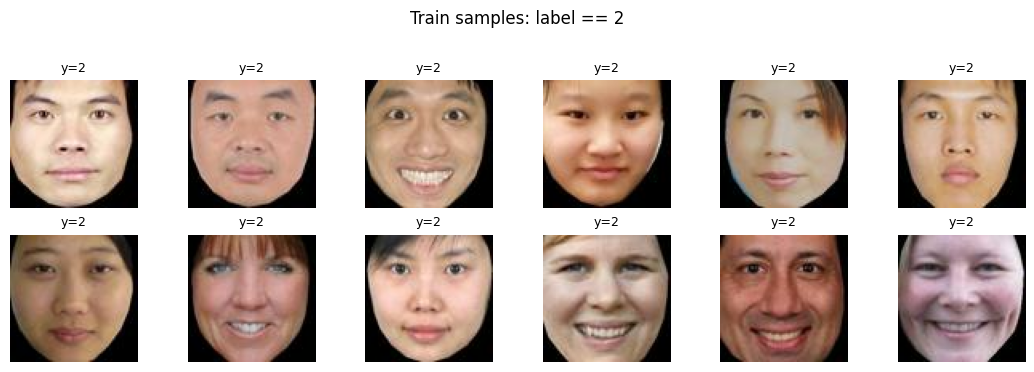

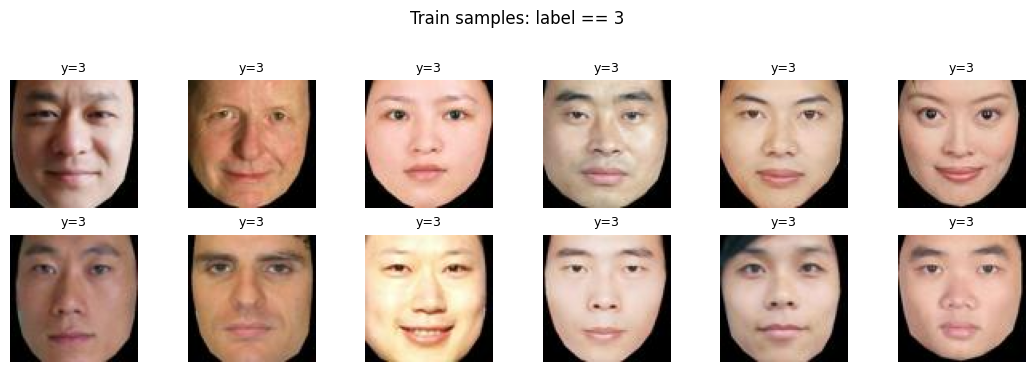

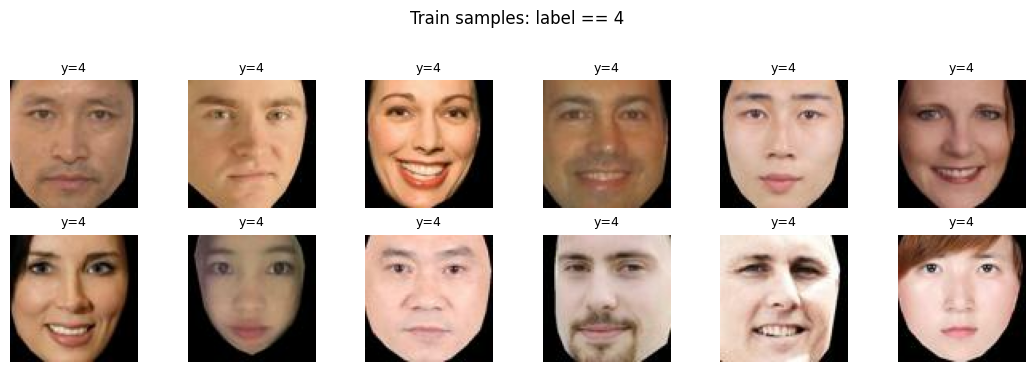

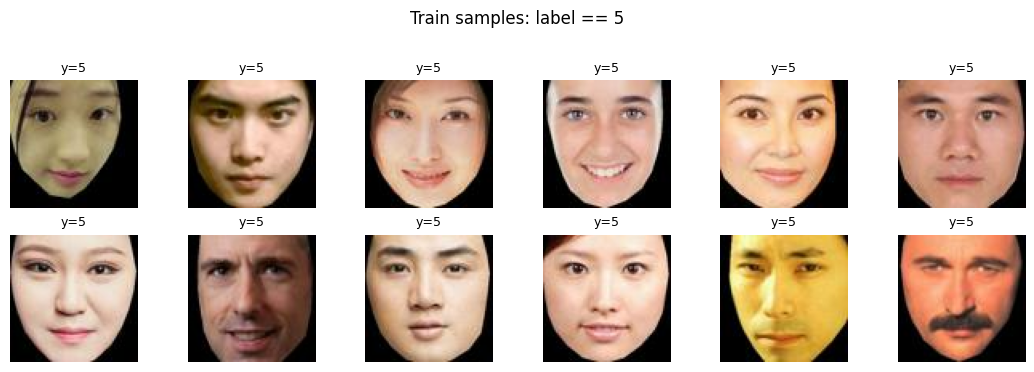

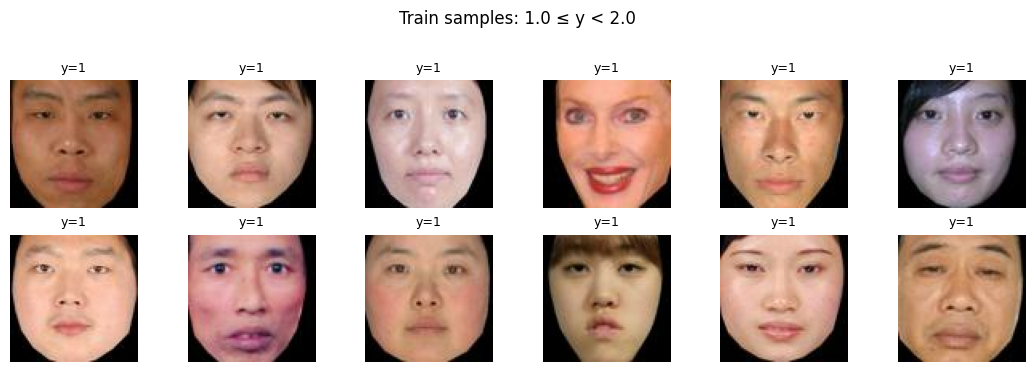

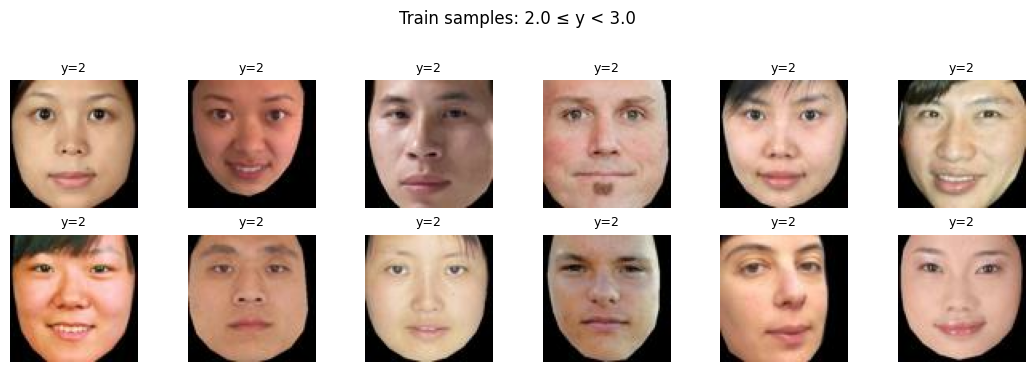

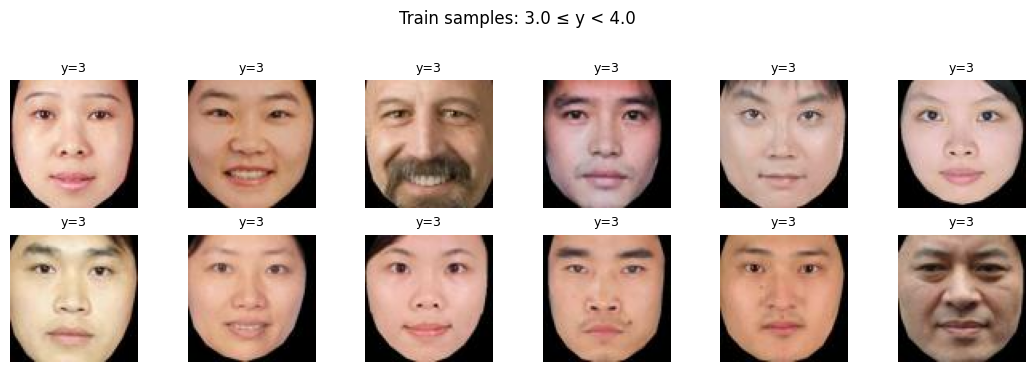

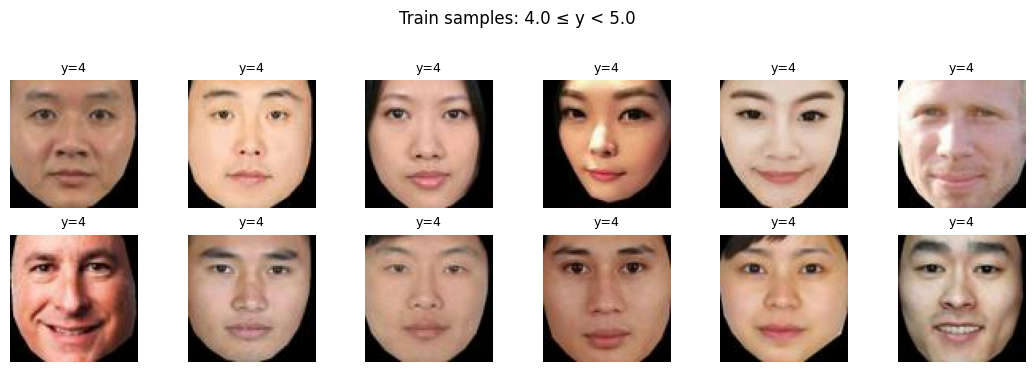

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
def plot_label_histogram(ds, title="Label histogram", bins=None, max_samples=None):
    labels = []
    n = 0
    for _, y in ds:
        y = tf.reshape(y, []).numpy().item()  # scalar
        labels.append(y)
        n += 1
        if max_samples is not None and n >= max_samples:
            break

    plt.figure(figsize=(6,4))
    if bins is None:
        # SCUT-FBP5500 labels are integers, usually 1..5. Force integer bins if desired.
        min_l, max_l = int(min(labels)), int(max(labels))
        bins = range(min_l, max_l + 2)  # inclusive edges for integers
    plt.hist(labels, bins=bins, edgecolor="black")
    plt.xlabel("Label"); plt.ylabel("Count"); plt.title(title)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Usage:
plot_label_histogram(train_dataset, title="Train label histogram", max_samples=100000)
plot_label_histogram(validation_dataset, title="Val label histogram")
def _collect_examples(ds, predicate, k):
    """Collect up to k examples (img,y) where predicate(y) is True."""
    bucket = []
    for img, y in ds.shuffle(2048):
        y = tf.reshape(y, []).numpy().item()
        if predicate(y):
            bucket.append((img.numpy(), y))
            if len(bucket) >= k:
                break
    return bucket

def sample_by_label_equal(ds, target_label, k=8):
    """Sample images whose label == target_label (int)."""
    return _collect_examples(ds, lambda y: int(round(y)) == int(target_label), k)

def sample_by_label_range(ds, lo, hi, k=8, inclusive_right=False):
    """Sample images with lo <= y < hi  (or <= hi if inclusive_right)."""
    if inclusive_right:
        return _collect_examples(ds, lambda y: (y >= lo) and (y <= hi), k)
    return _collect_examples(ds, lambda y: (y >= lo) and (y < hi), k)

def show_grid(examples, title="", cols=8):
    if not examples:
        print("No examples to show.")
        return
    imgs = [e[0] for e in examples]
    ys   = [e[1] for e in examples]
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i, (im, y) in enumerate(zip(imgs, ys)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(np.clip(im, 0, 1))
        ax.set_title(f"y={int(round(y))}", fontsize=9)
        ax.axis("off")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()
for L in [1, 2, 3, 4, 5]:
    exs = sample_by_label_equal(train_dataset, L, k=12)
    show_grid(exs, title=f"Train samples: label == {L}", cols=6)
bins = [(1.0,2.0), (2.0,3.0), (3.0,4.0), (4.0,5.0)]
for lo, hi in bins:
    exs = sample_by_label_range(train_dataset, lo, hi, k=12)
    show_grid(exs, title=f"Train samples: {lo} ≤ y < {hi}", cols=6)


# Model Creation

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history.get("val_loss", []), label="val")
  plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
  plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model, callbacks

class SingleBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(
            total=self.params['epochs'],
            desc='training',
            leave=False,              # keeps it to a single rolling line
            dynamic_ncols=True,
            bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tail = {k: f"{logs[k]:.4f}" for k in ("loss","mse","rounded_mae") if k in logs}
        # 1) set postfix WITHOUT forcing an immediate refresh
        self.pbar.set_postfix(tail, refresh=False)
        # 2) now advance the bar (this triggers a single refresh)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

class AttractRegressorModel(Model):
    def __init__(self, architecture:dict):
        super().__init__()
        self.architecture = architecture
        self.layer_list = self._build_model(architecture)
        self.is_sequential = self.architecture.get("computation_sequence", "sequential") == "sequential"
        if self.is_sequential:
          self.layer_list = tf.keras.Sequential(self.layer_list)
        #for residuality
        self.residual_map = {}
        self.required_outputs = set()
        if not self.is_sequential:
            self._parse_computation_sequence()

    def _parse_computation_sequence(self, architecture):
        computation_sequence = self.architecture.get("computation_sequence")
        for conn_str in computation_sequence:
            try:
                start, end = map(int, conn_str.split('-'))
                if start >= end:
                    raise ValueError(f"Start index ({start}) must be less than end index ({end}) in connection '{conn_str}'.")

                # Map the end point to the start point for quick lookups
                self.residual_map[end] = start

                # We need to store the output of the layer *before* the start index
                self.required_outputs.add(start - 1)
                print(f"  - Will add output of layer {start - 1} to output of layer {end}")

            except ValueError as e:
                raise ValueError(f"Invalid connection format: '{conn_str}'. Expected 'start-end'. Details: {e}")

    def _build_cnn_layer(self,params):
      return L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            kernel_initializer=params.get("initialization", "he_normal"),
            use_bias=params.get("use_bias", True)
        ) if "dilation" not in params else L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            dilation_rate=params.get("dilation", 1),
            kernel_regularizer=tf.keras.regularizers.l2(params.get("l2_rate", 0)),
            use_bias=params.get("use_bias", True)
        )

    def _build_maxpool_layer(self,params):
      return L.MaxPooling2D(
            pool_size=params.get("pool_size", 2),
            strides=params.get("strides", 2)
        )

    def _build_batchnorm_layer(self,layer):
      return L.BatchNormalization()

    def _build_activation_layer(self, params: dict):
        name = params.get("name", "relu").lower()
        if name == 'leakyrelu':
            return L.LeakyReLU(alpha=params.get("alpha", 0.1))
        return L.Activation(name)

    def _build_dropout_layer(self, params):
      return L.Dropout(rate=params.get("rate", 0.5))

    def _build_last_layer(self, params: dict):
      """
      Builds the final block of the network (the head).
      This can be a multi-layer sequence, so it returns a Sequential model.
      """
      head_type = params.get("head_type", "mlp") # Default to mlp
      drop = float(params.get("dropout_rate", 0.0) or 0.0)
      if head_type == "mlp":
        print("  - Building MLP Head (Flatten -> Dense [+ optional Dropout])")
        layers = [
            L.Flatten(),
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(1)
        ]
        return tf.keras.Sequential(layers)

      elif head_type == "fully_convolutional":
        print("  - Building FCN Head (GlobalAvgPool -> Dense)")
        return tf.keras.Sequential([
            L.GlobalAveragePooling2D(),
            L.Dense(64, activation="relu"),
            L.Dense(1)
        ])
      else:
        raise ValueError(f"Unknown last_layer head_type: {head_type}")

    def _build_model(self,architecture):
      modules = []
      build_maps = {
          "cnn": self._build_cnn_layer,
          "maxpool": self._build_maxpool_layer,
          "batchnorm": self._build_batchnorm_layer,
          "activation": self._build_activation_layer,
          "last_layer": self._build_last_layer,
          "dropout": self._build_dropout_layer
      }
      for module in architecture["layers"]:
          if module["type"] == "noop":
            continue
          build_function = build_maps[module["type"]]
          layer = build_function(module)
          modules.append(layer)
      return modules

    def call(self, inputs, training=False):
        # Sequential Operations
        if self.is_sequential:
            return self.layer_list(inputs, training=training)

        # If there are skip connections:
        outputs_cache = {}
        x = inputs
        # Check if the initial input tensor needs to be stored for a connection
        if 0 in self.required_outputs:
            outputs_cache[0] = x

        # --- Main Forward Pass with Inline Additions ---
        for i, layer in enumerate(self.layer_list): ## even though Activations are not a layer we treated as it is.
            layer_num = i + 1

            # Forward passing
            x = layer(x, training=training)

            # If this layer is an endpoint for a residual connection, perform the addition
            if layer_num in self.residual_map:
                start_idx = self.residual_map[layer_num]

                if (start_idx - 1) not in outputs_cache:
                    raise RuntimeError(f"Logic error: Required output from layer {start_idx - 1} was not cached.")

                shortcut_path = outputs_cache[start_idx - 1]

                # --- Shape Validation ---
                if x.shape[1:] != shortcut_path.shape[1:]:
                    raise ValueError(
                        f"Shape mismatch for residual connection {start_idx}-{layer_num}. "
                        f"Cannot add shortcut shape {shortcut_path.shape} to main shape {x.shape}. "
                        "You may need a projection layer (1x1 Conv) to match dimensions."
                    )

                # Perform the addition, which now becomes the main path tensor 'x'
                x = L.Add()([x, shortcut_path])

            # Check if the activation output is the residual for feature
            if layer_num in self.required_outputs:
                outputs_cache[layer_num] = x

        return x

In [ ]:

# ====== plotting: train + val ======
import matplotlib.pyplot as plt

def plot_train_val_history(hist, title="Training"):
    e = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(13,6))

    # Loss (MSE loss)
    plt.subplot(1,2,1)
    plt.plot(e, hist["loss"], label="train loss")
    if "val_loss" in hist: plt.plot(e, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()

    # MAE (rounded)
    plt.subplot(1,2,2)
    # If you also log unrounded MAE, you can plot it too; here we focus on rounded MAE per the assignment
    if "rounded_mae" in hist:       plt.plot(e, hist["rounded_mae"], label="train rMAE")
    if "val_rounded_mae" in hist:   plt.plot(e, hist["val_rounded_mae"], label="val rMAE")
    # (optionally show unrounded)
    if "mean_absolute_error" in hist:        plt.plot(e, hist["mean_absolute_error"], '--', alpha=0.5, label="train MAE")
    if "val_mean_absolute_error" in hist:    plt.plot(e, hist["val_mean_absolute_error"], '--', alpha=0.5, label="val MAE")

    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def prepare_train(ds, batch_size=32, seed=1337):
    return (ds
            .shuffle(8192, seed=seed, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

# Useful utility tool for adding l2 regularization to layers
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers

def prepare_val(ds, batch_size=32):
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
from IPython.display import clear_output

class LivePlot(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.h = {"loss":[], "val_loss":[], "mean_absolute_error":[], "val_mean_absolute_error":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.h.keys():
            if k in logs: self.h[k].append(logs[k])
        clear_output(wait=True)
        e = range(1, len(self.h["loss"])+1)
        plt.figure(figsize=(13,6))
        # Loss
        plt.subplot(1,2,1)
        plt.plot(e, self.h["loss"], label="train loss")
        if self.h["val_loss"]: plt.plot(e, self.h["val_loss"], label="val loss")
        plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
        # MAE
        plt.subplot(1,2,2)
        if self.h["mean_absolute_error"]: plt.plot(e, self.h["mean_absolute_error"], '--', label="train MAE")
        if self.h["val_mean_absolute_error"]: plt.plot(e, self.h["val_mean_absolute_error"], '--', label="val MAE")
        plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss="mse",
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")


    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]
    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last = {
        "loss": h["loss"][-1],
        "val_loss": h.get("val_loss", float("nan"))[-1],
        "mean_absolute_error": h.get("mean_absolute_error", [float("nan")])[-1],
        "val_mean_absolute_error": h.get("val_mean_absolute_error", [float("nan")])[-1],
    }
    print(last)
    print(f"[{name}] last: loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"rMAE={last['mean_absolute_error']:.4f} | val_rMAE={last['val_mean_absolute_error']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")

    return h

Model Visualization Utils

Building VGG Like Architecture Let's Focus on Max Pooling and Dilations. Which one is better and why?

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers
def create_vgg_16_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, cnn_initialization_type="he_normal", fc_init_type="he_normal"):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  # VGG16 Layers
  if not all_layers_dropout:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  else:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  if l2_norm > 0:
    add_l2_to_layers(vgg16_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_layers,
      "computation_sequence": "sequential"
  }
  return vgg16_config
def create_vgg16_dilated_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, initialization_type="he_normal", remove_bias=False):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  vgg16_dilated_layers = []
  if not all_layers_dropout:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
    ]
    print(f"Entered here. {vgg16_dilated_layers}")
  else:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},

        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        {"type": "last_layer", "head_type": "mlp","dropout_rate": dropout_rate}
    ]
  print(vgg16_dilated_layers)
  if l2_norm > 0:
    add_l2_to_layers(vgg16_dilated_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  vgg_dilated_layers_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  return vgg_dilated_layers_config

def build_model(vgg_model_config):
  vgg_model = AttractRegressorModel(vgg_model_config)
  return vgg_model


# Now running configurations

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 70

Default model

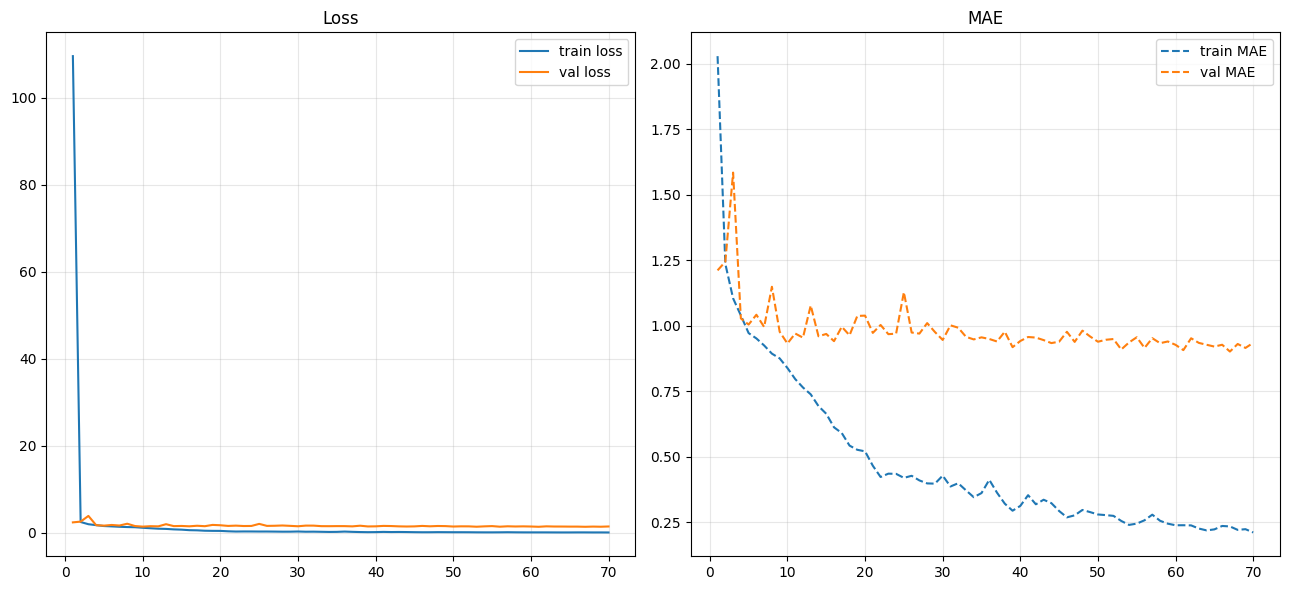



training: 100%|██████████ 70/70 [25:07<00:00] , loss=0.0745, mse=0.0745

                                                                       

[2.393787145614624, 2.5667972564697266, 3.876904249191284, 1.742603063583374, 1.6426995992660522, 1.797416090965271, 1.6672505140304565, 2.080918073654175, 1.5491336584091187, 1.4171969890594482, 1.5147342681884766, 1.480135202407837, 1.974926471710205, 1.5331026315689087, 1.571541428565979, 1.4910027980804443, 1.616805076599121, 1.5155198574066162, 1.8111488819122314, 1.7302381992340088, 1.578978419303894, 1.643975853919983, 1.5557347536087036, 1.5700653791427612, 2.0464060306549072, 1.5852248668670654, 1.614930510520935, 1.6764627695083618, 1.5914201736450195, 1.50001060962677, 1.6492475271224976, 1.6455711126327515, 1.5265713930130005, 1.516725778579712, 1.535129427909851, 1.5304275751113892, 1.4761587381362915, 1.6257528066635132, 1.4585522413253784, 1.4842157363891602, 1.5811086893081665, 1.5491669178009033, 1.477169394493103, 1.4425126314163208, 1.4711942672729492, 1.5784796476364136, 1.4910656213760376, 1.5606430768966675, 1.5353846549987793, 1.4366989135742188, 1.48345053195953

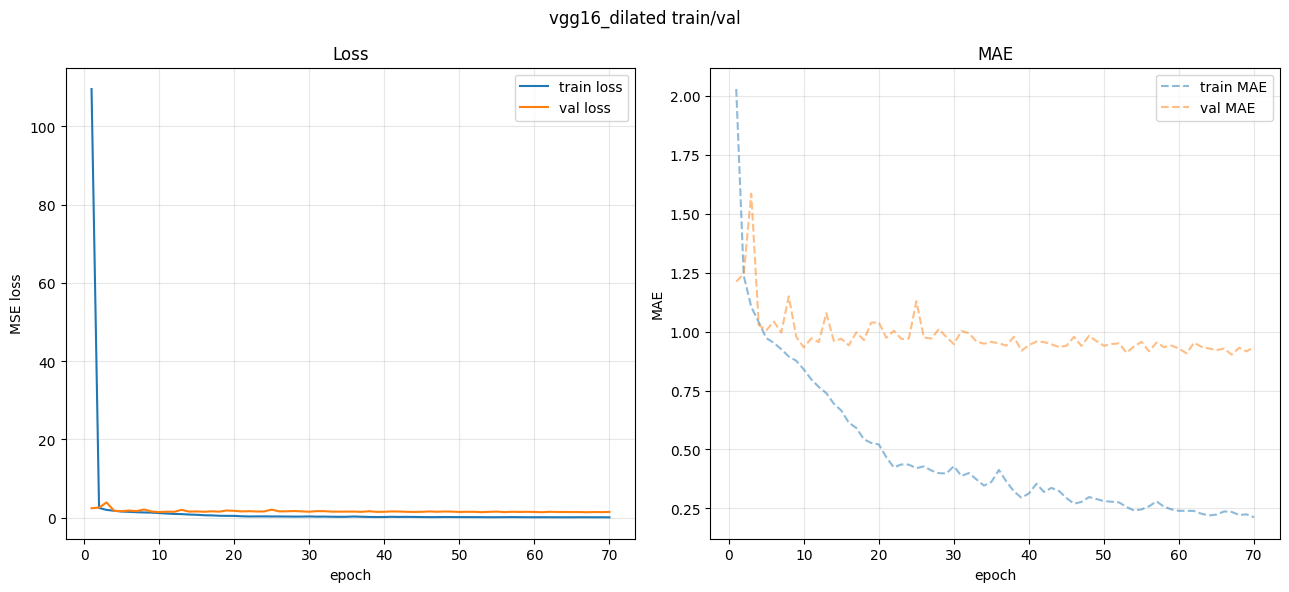

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 70
dilated_vgg= build_model(create_vgg16_dilated_configs())
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)



Default + Early stopping and reduce lr on plateau

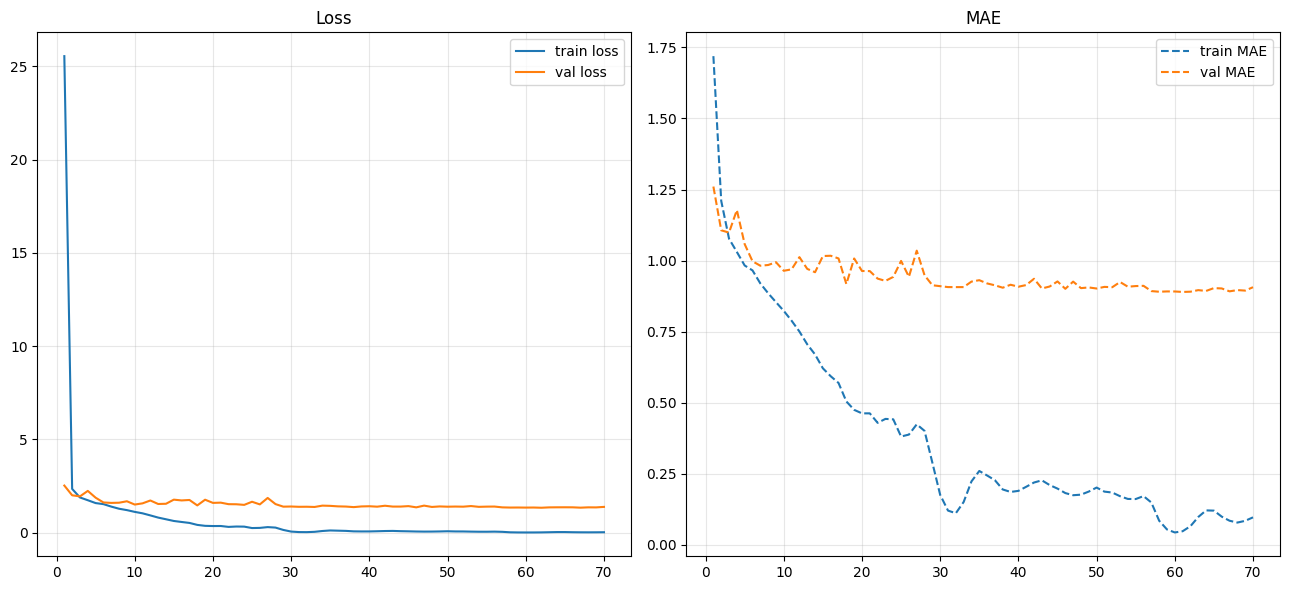


training: 100%|██████████ 70/70 [25:17<00:00] , loss=0.0157, mse=0.0157
                                                                       

Restoring model weights from the end of the best epoch: 61.
[2.518662929534912, 1.9964814186096191, 1.9384989738464355, 2.2325057983398438, 1.8688355684280396, 1.6124662160873413, 1.5885403156280518, 1.5987002849578857, 1.6765004396438599, 1.500058650970459, 1.564221739768982, 1.7178521156311035, 1.5302342176437378, 1.5424667596817017, 1.7628836631774902, 1.7211307287216187, 1.7459124326705933, 1.4542962312698364, 1.759828805923462, 1.5893938541412354, 1.6023744344711304, 1.5204010009765625, 1.5154963731765747, 1.4829262495040894, 1.650265097618103, 1.5086901187896729, 1.8543962240219116, 1.5249208211898804, 1.387116551399231, 1.3951938152313232, 1.3793660402297974, 1.382836937904358, 1.370543360710144, 1.442509651184082, 1.4299094676971436, 1.402794599533081, 1.3927497863769531, 1.362689733505249, 1.3991492986679077, 1.4095042943954468, 1.386348009109497, 1.4361655712127686, 1.3911633491516113, 1.3913614749908447, 1.415961503982544, 1.350685477256775, 1.4431034326553345, 1.37155592441

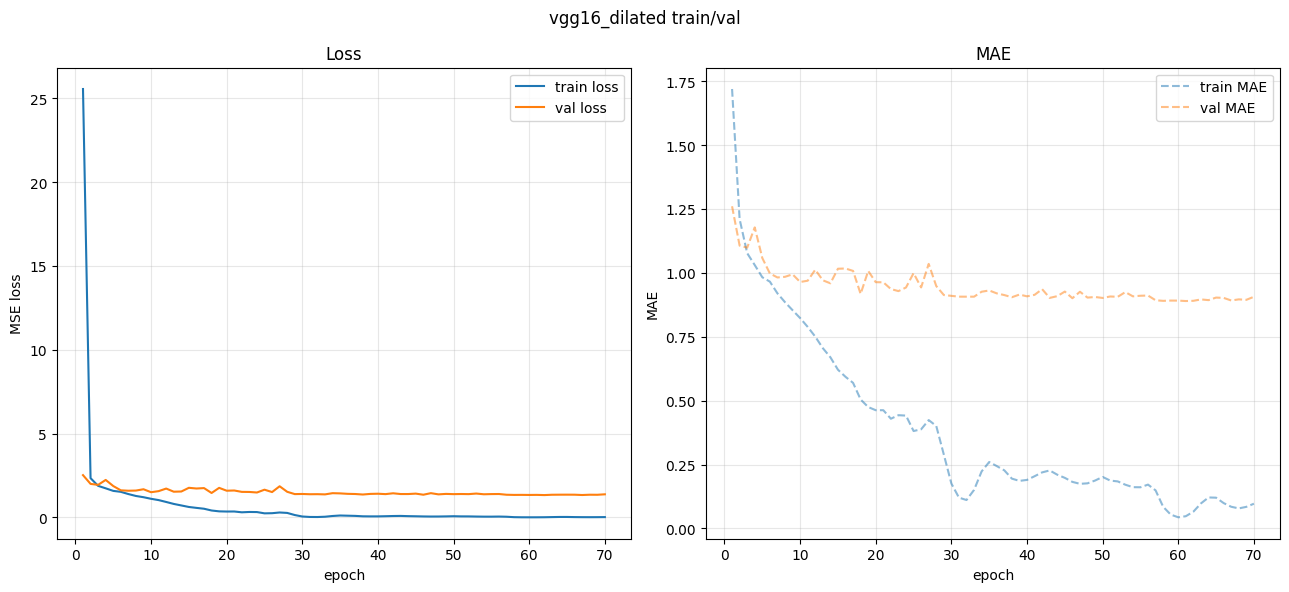

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs())
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)

Batch norm added

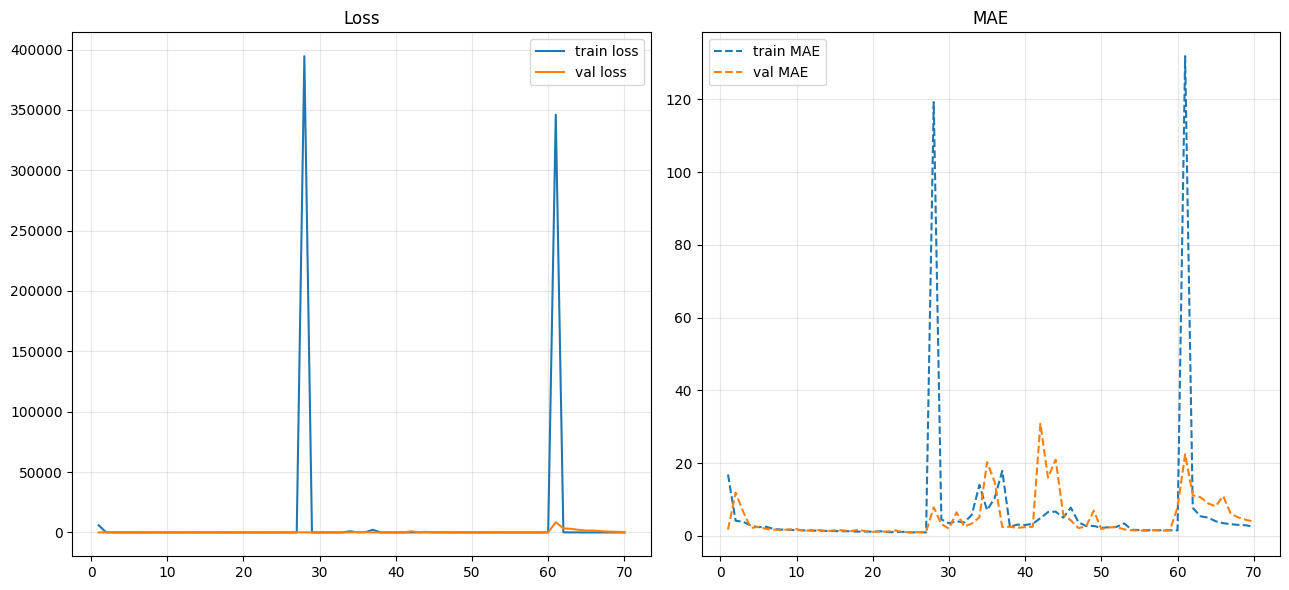


training: 100%|██████████ 70/70 [28:45<00:00] , loss=10.0267, mse=10.0267
                                                                         

[5.235011100769043, 173.99241638183594, 101.11801147460938, 7.594304084777832, 11.475354194641113, 6.188927173614502, 5.4818220138549805, 3.857056140899658, 6.491795539855957, 10.022401809692383, 3.052280902862549, 5.4601263999938965, 7.7075982093811035, 4.578228950500488, 8.153881072998047, 8.692266464233398, 4.1259446144104, 11.437719345092773, 3.5745184421539307, 2.1410131454467773, 2.0713307857513428, 2.271632432937622, 3.242400646209717, 1.6800987720489502, 1.6013050079345703, 1.8255137205123901, 2.0246975421905518, 134.30055236816406, 17.741436004638672, 6.975780487060547, 47.49653625488281, 9.522212982177734, 14.897934913635254, 61.025482177734375, 427.3883361816406, 237.7008514404297, 22.621749877929688, 19.886362075805664, 14.823639869689941, 12.25670051574707, 12.667244911193848, 980.9049682617188, 266.52520751953125, 451.229248046875, 41.658042907714844, 23.189035415649414, 7.866057872772217, 9.039348602294922, 55.2575798034668, 5.801477909088135, 10.549759864807129, 9.58795

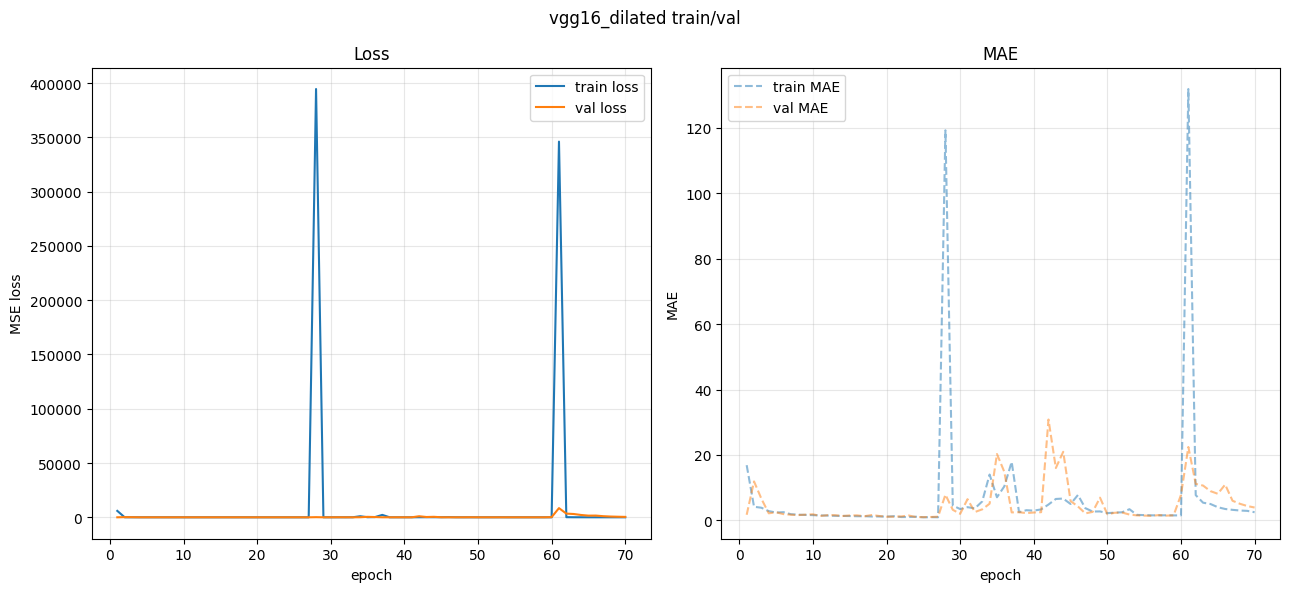

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)

Batchnorm + L2

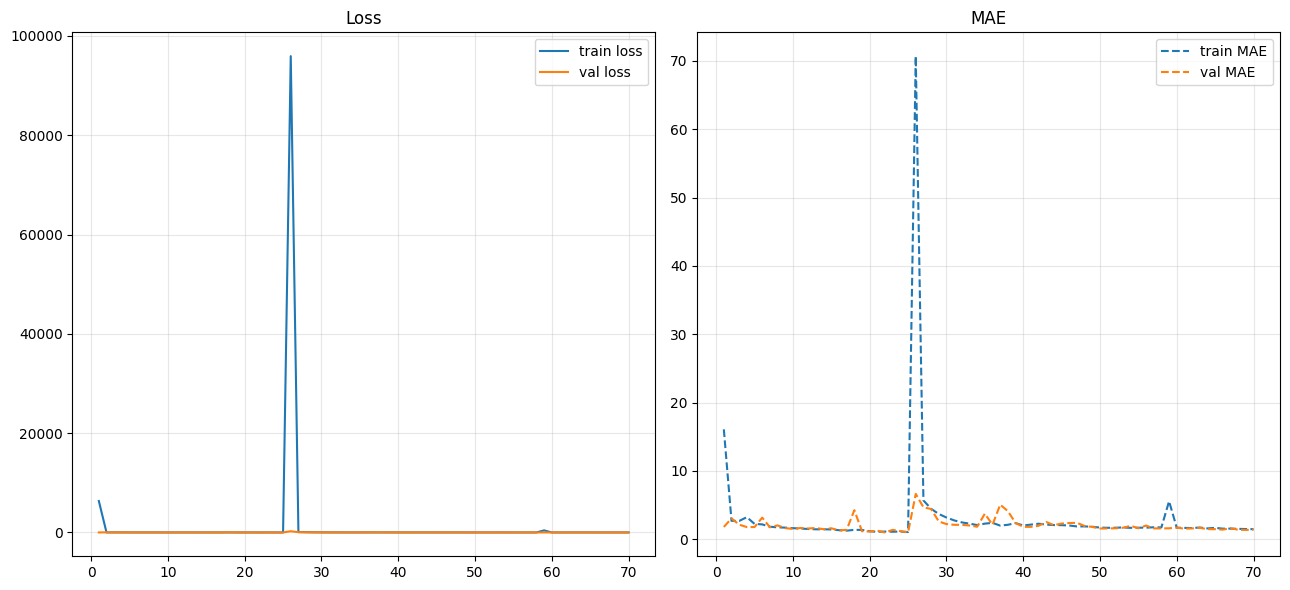


training: 100%|██████████ 70/70 [28:41<00:00] , loss=3.9321, mse=3.3984
                                                                       

[6.25181245803833, 25.85129165649414, 14.25965690612793, 6.123270034790039, 6.270788192749023, 16.1573429107666, 5.6441240310668945, 8.003378868103027, 4.441723823547363, 3.9078102111816406, 6.263253688812256, 5.005832195281982, 6.600564479827881, 3.7619431018829346, 4.804213047027588, 3.348888635635376, 3.765446662902832, 54.78370666503906, 2.5519323348999023, 2.3651928901672363, 3.2660722732543945, 1.9448864459991455, 3.1804120540618896, 2.4860546588897705, 1.996088981628418, 253.0621795654297, 56.94661331176758, 33.967132568359375, 15.957168579101562, 10.618513107299805, 9.370654106140137, 8.621169090270996, 7.976059436798096, 6.556952953338623, 18.98764991760254, 8.131959915161133, 30.698190689086914, 21.36863136291504, 8.197032928466797, 6.32560920715332, 5.575459957122803, 7.023173809051514, 10.022216796875, 7.904487133026123, 8.860363960266113, 8.071065902709961, 10.585554122924805, 5.641539573669434, 4.703789710998535, 4.101373672485352, 4.561905860900879, 4.234383583068848, 5.

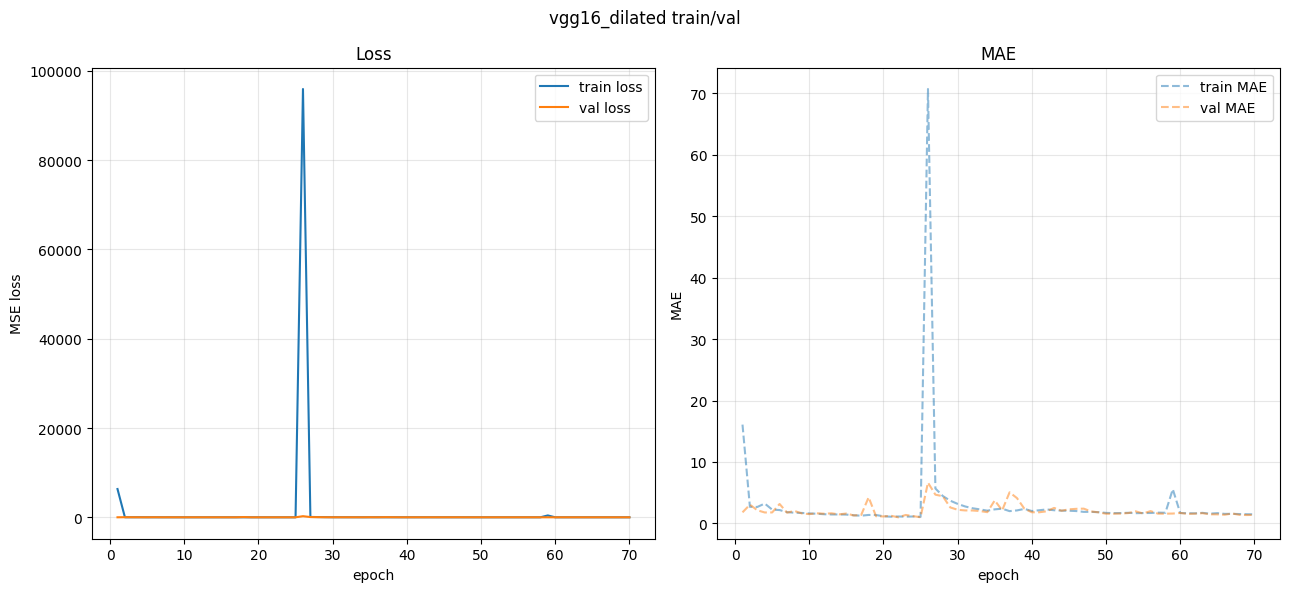

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=False
)

Batchnorm + Early stopping + reducelr on valdiation plateau

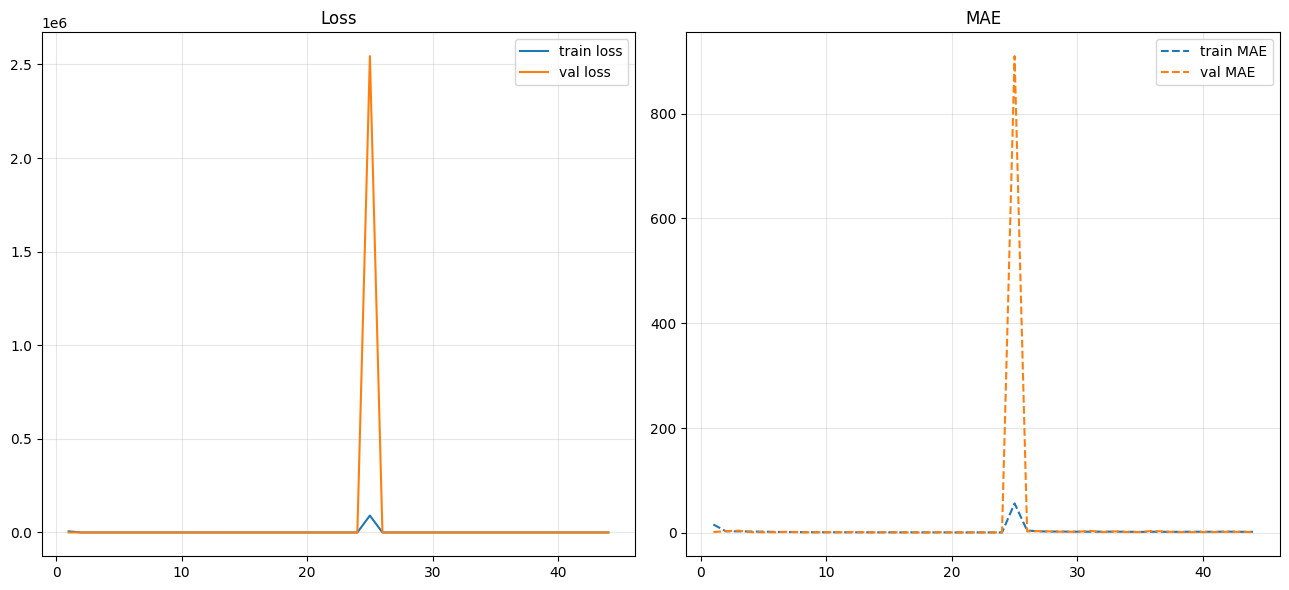


training:  63%|██████▎    44/70 [18:18<10:36] , loss=7.8119, mse=7.8119


Epoch 44: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 24.
[4.4427170753479, 15.707964897155762, 32.82743453979492, 4.083046913146973, 3.431650400161743, 3.1688218116760254, 6.982048034667969, 2.9254815578460693, 2.574261426925659, 3.977931499481201, 2.9162180423736572, 4.363397121429443, 2.638312578201294, 2.4472174644470215, 3.2337868213653564, 1.833528995513916, 1.7227897644042969, 1.842660665512085, 2.769803524017334, 2.185961961746216, 1.8701667785644531, 2.151074171066284, 1.715073585510254, 1.6786595582962036, 2544148.25, 20.299108505249023, 20.60831642150879, 14.303302764892578, 9.62797737121582, 8.182757377624512, 20.680110931396484, 5.271235466003418, 12.165923118591309, 5.246392726898193, 4.478547096252441, 18.756025314331055, 8.893847465515137, 3.8434598445892334, 3.7272467613220215, 4.66495418548584, 4.083519458770752, 7.936220645904541, 6.555254936218262, 4.702348232269287]
{'loss': 7.811865329742432, 'val_loss': 4.702348232269287, 'mean_absolute

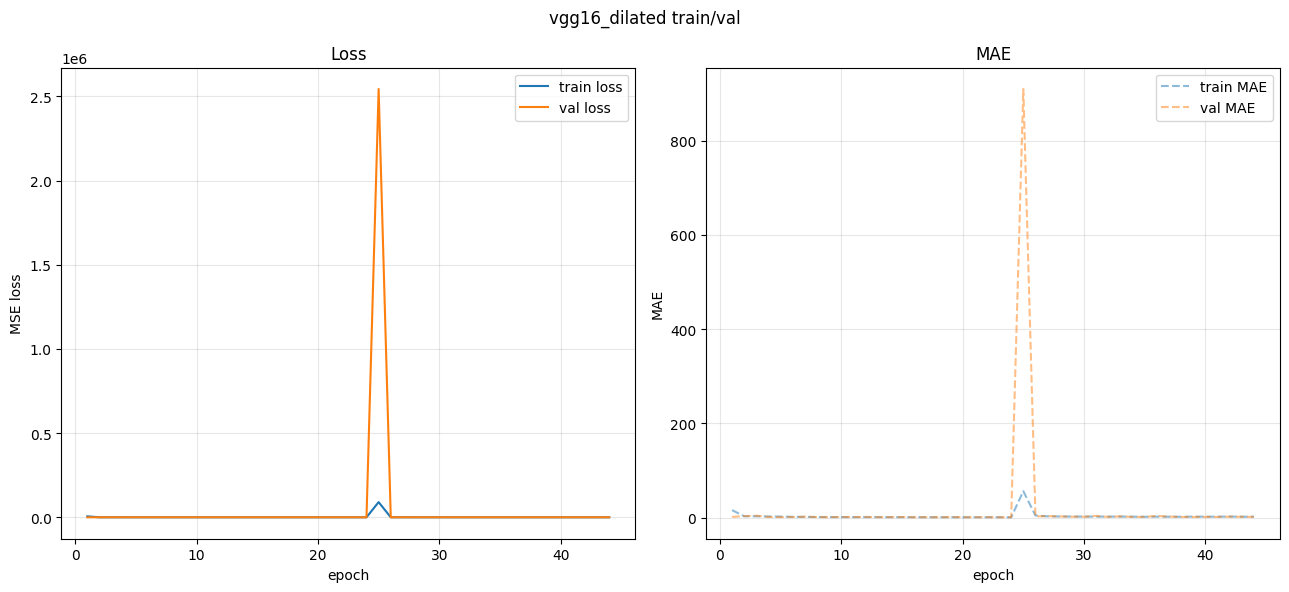

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)

Batchnorm + L2 + early stop + reduce lr on plateau

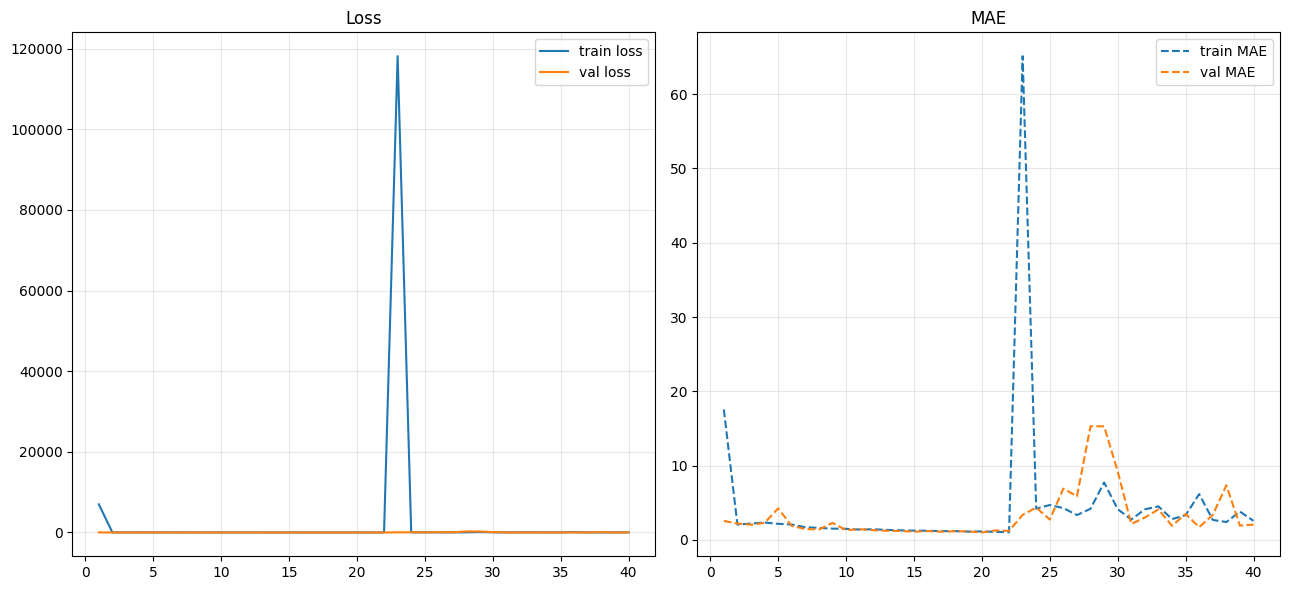


training:  57%|█████▋     40/70 [16:34<12:09] , loss=11.2737, mse=10.8506


Epoch 40: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 20.
[9.031028747558594, 7.080637454986572, 7.343011856079102, 8.245210647583008, 22.948266983032227, 5.891898155212402, 3.8392460346221924, 3.488018274307251, 7.801592826843262, 3.0107808113098145, 3.7027714252471924, 3.216156482696533, 2.7767348289489746, 2.6351277828216553, 2.2905075550079346, 2.5845677852630615, 2.2373194694519043, 2.4631292819976807, 2.510672092437744, 2.0074260234832764, 2.825183629989624, 2.6607139110565186, 34.15216827392578, 46.10227584838867, 27.11658477783203, 61.35541915893555, 40.197410583496094, 253.14625549316406, 253.01486206054688, 97.9705810546875, 8.94861125946045, 12.688901901245117, 21.523881912231445, 5.475693702697754, 16.611549377441406, 5.420429706573486, 16.52088165283203, 61.124183654785156, 5.437741756439209, 6.390071868896484]
{'loss': 11.27374267578125, 'val_loss': 6.390071868896484, 'mean_absolute_error': 2.55661940574646, 'val_mean_absolute_error': 2.05161118

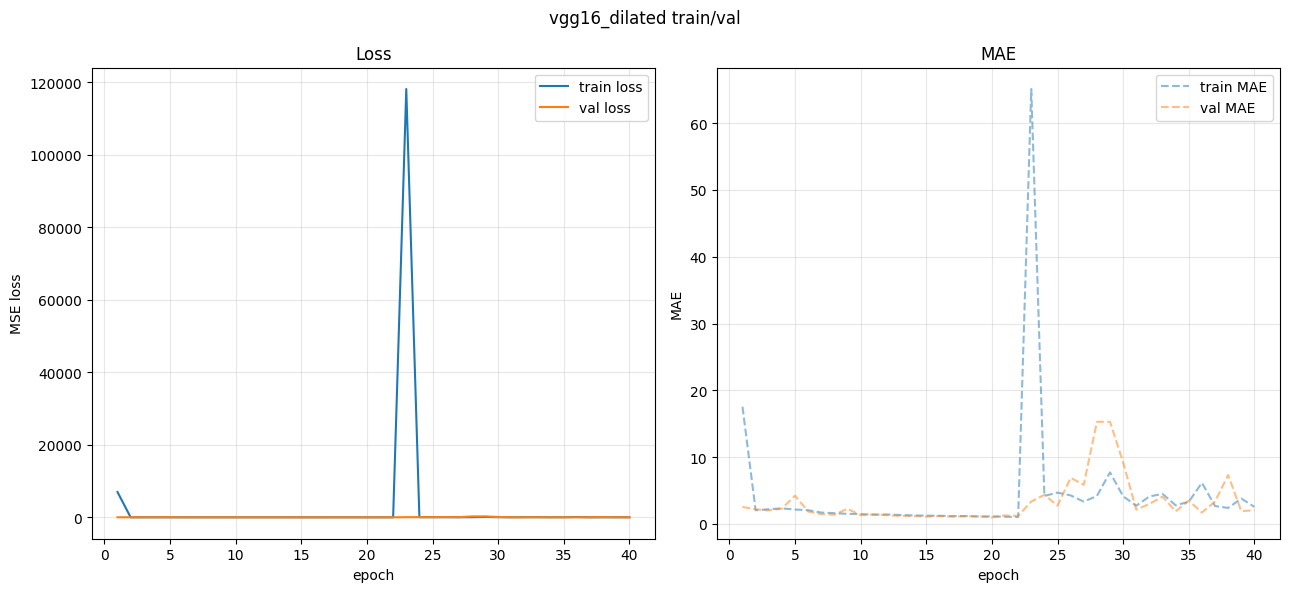

In [ ]:
del dilated_vgg

dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

# Different Initializations (Xavier /2 or He normal Init vs Xavier Initialization)

Previous runs are made with he normal. Now runing with glorot uniform

Xavier Initialization

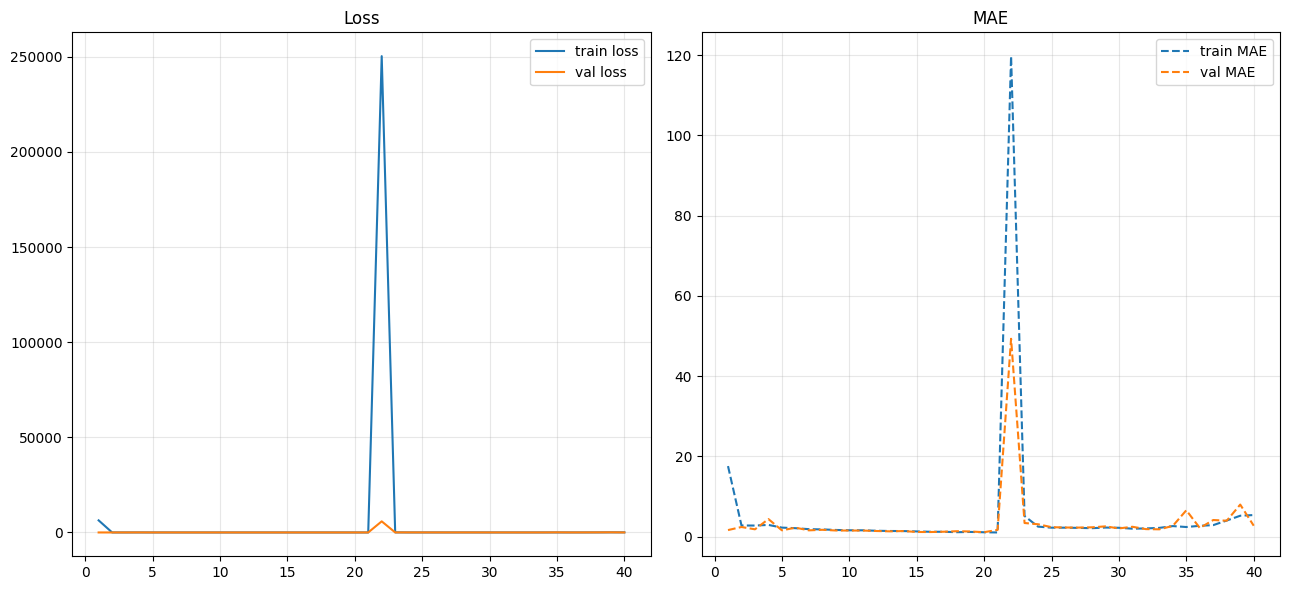


training:  57%|█████▋     40/70 [16:35<12:21] , loss=53.3866, mse=52.9768


Epoch 40: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 20.
[4.476616859436035, 8.252318382263184, 5.185573101043701, 22.967819213867188, 4.163916110992432, 8.282191276550293, 3.8192598819732666, 4.128732681274414, 4.4819135665893555, 3.5935001373291016, 3.5550811290740967, 3.3871946334838867, 3.1421854496002197, 3.3446481227874756, 2.522470712661743, 2.439845561981201, 2.8069632053375244, 3.2462821006774902, 2.895200729370117, 2.3318865299224854, 5.845683574676514, 5840.10595703125, 27.616432189941406, 22.891704559326172, 20.346542358398438, 19.409719467163086, 12.0676908493042, 18.41035270690918, 18.20684051513672, 9.66430950164795, 13.401963233947754, 8.586596488952637, 7.635704040527344, 13.813018798828125, 61.1900749206543, 13.95276927947998, 27.577360153198242, 45.56106948852539, 73.71675872802734, 12.85762882232666]
{'loss': 53.38656997680664, 'val_loss': 12.85762882232666, 'mean_absolute_error': 5.3780517578125, 'val_mean_absolute_error': 2.719418287277

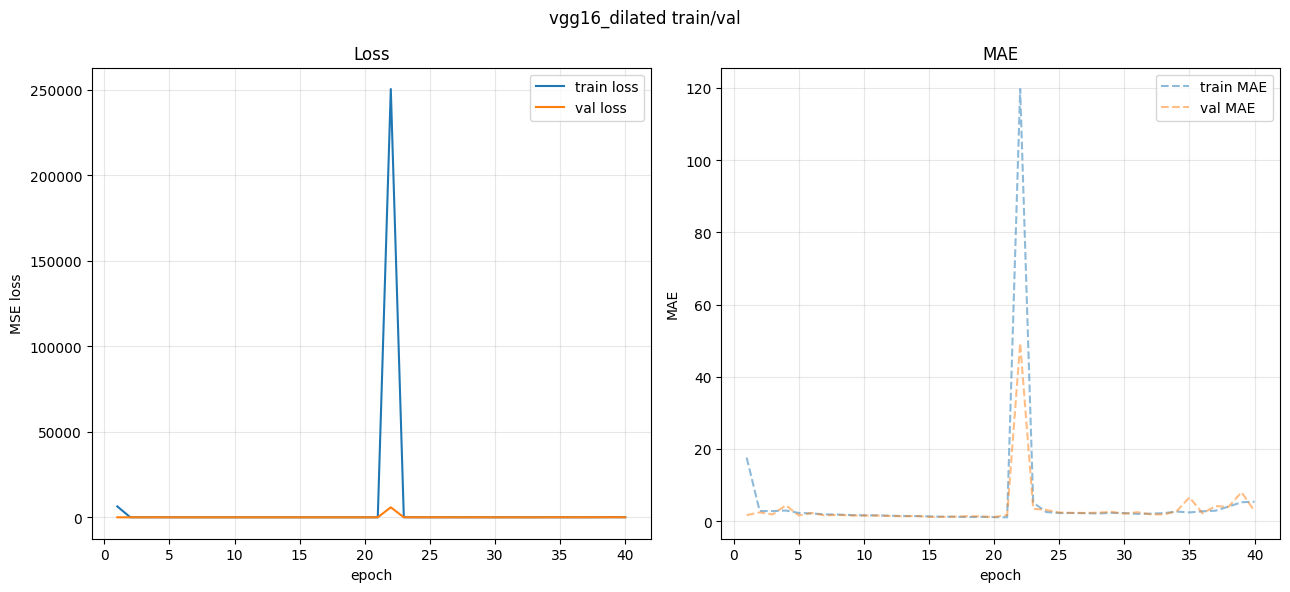

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-4, initialization_type="glorot_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Random Initialization

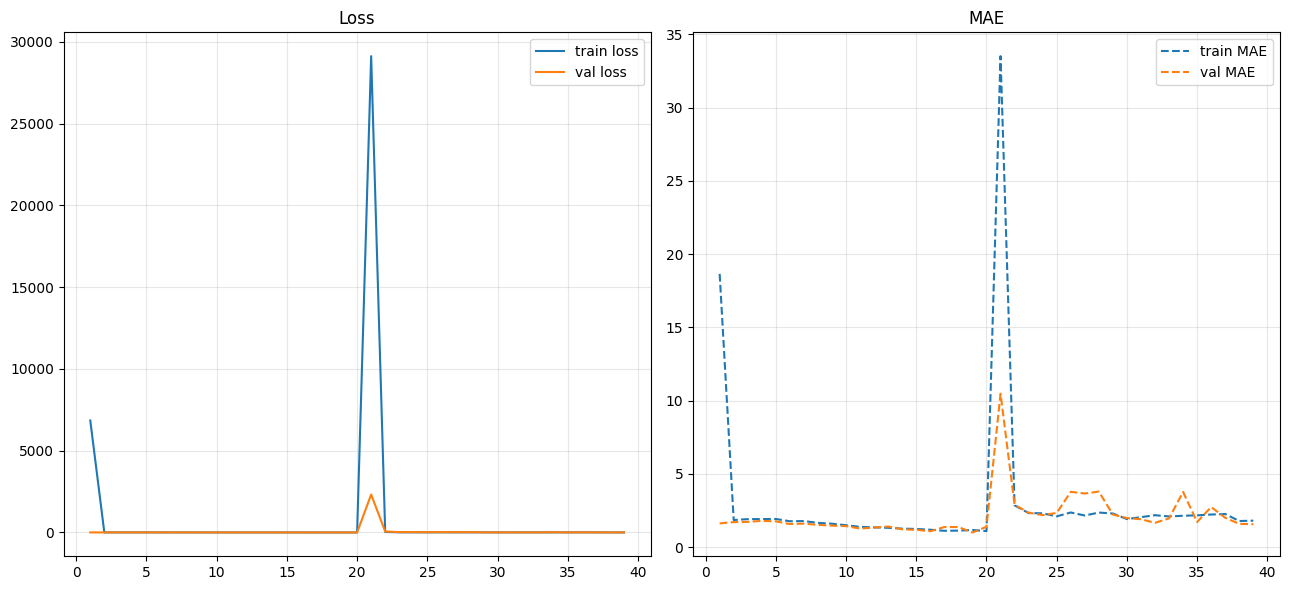


training:  56%|█████▌     39/70 [16:11<12:36] , loss=5.4264, mse=5.0201


Epoch 39: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
[4.221410751342773, 4.71719217300415, 5.437087535858154, 5.838200092315674, 5.869083404541016, 4.442413330078125, 4.873401641845703, 4.013443946838379, 3.699160575866699, 3.545135736465454, 2.945422649383545, 3.2224996089935303, 3.511061429977417, 2.757936716079712, 2.627811908721924, 2.1772680282592773, 3.3602123260498047, 3.3515281677246094, 1.9611808061599731, 3.2234387397766113, 2320.792236328125, 61.402915954589844, 22.72515869140625, 21.917016983032227, 16.269485473632812, 21.752187728881836, 18.997982025146484, 19.700899124145508, 7.29982852935791, 7.391164779663086, 6.863614082336426, 5.0889506340026855, 5.565953731536865, 18.403369903564453, 4.54701042175293, 10.540693283081055, 5.669003963470459, 4.565896511077881, 3.990596294403076]
{'loss': 5.426412582397461, 'val_loss': 3.990596294403076, 'mean_absolute_error': 1.813377022743225, 'val_mean_absolute_error': 1.5720889568328857}
[vgg16_dilate

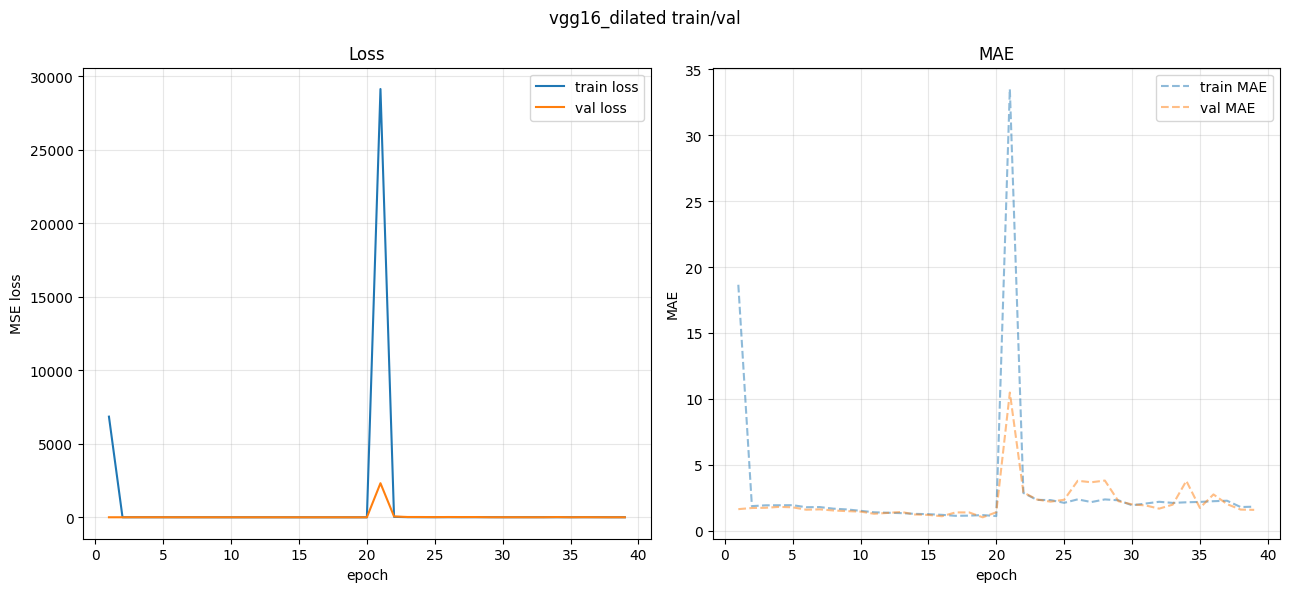

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-4, initialization_type="random_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

# Without Batchnorm
Experiments Without Batch norm Direct l2 reg and different initializaitons as batchnorm caused problem

## Xavier (glorot) initialization

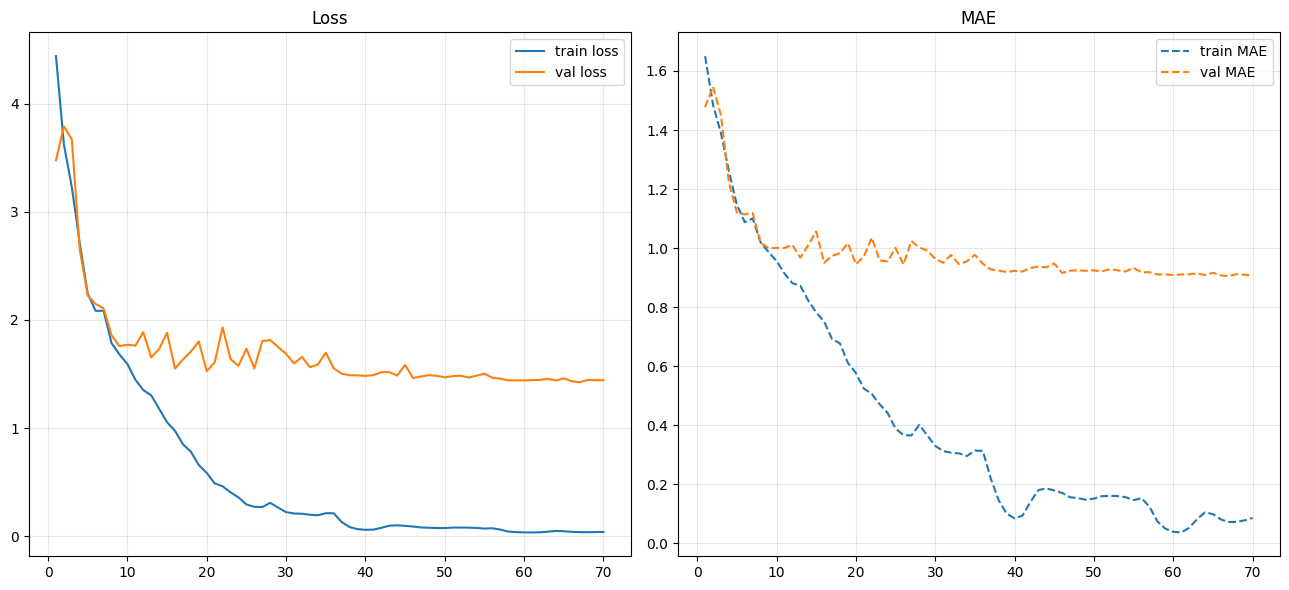

Restoring model weights from the end of the best epoch: 67.


[3.4763829708099365, 3.7901687622070312, 3.6673357486724854, 2.6493165493011475, 2.2256014347076416, 2.1482391357421875, 2.1076996326446533, 1.8596866130828857, 1.7575379610061646, 1.7713284492492676, 1.7624781131744385, 1.8870874643325806, 1.65483558177948, 1.7306747436523438, 1.882924199104309, 1.5506529808044434, 1.6352485418319702, 1.7078925371170044, 1.801621675491333, 1.5271450281143188, 1.6084595918655396, 1.931700348854065, 1.6384941339492798, 1.5754693746566772, 1.734932780265808, 1.5527666807174683, 1.8044743537902832, 1.8152748346328735, 1.7486246824264526, 1.6875419616699219, 1.597908616065979, 1.658189296722412, 1.5645792484283447, 1.5872701406478882, 1.6971993446350098, 1.5544079542160034, 1.5032950639724731, 1.4893189668655396, 1.488028645515442, 1.4831295013427734, 1.4905622005462646, 1.5171351432800293, 1.5187541246414185, 1.4864753484725952, 1.5846508741378784, 1.4623194932937622, 1.4778064489364624, 1.489554524421692, 1.4839799404144287, 1.4700543880462646, 1.4808626

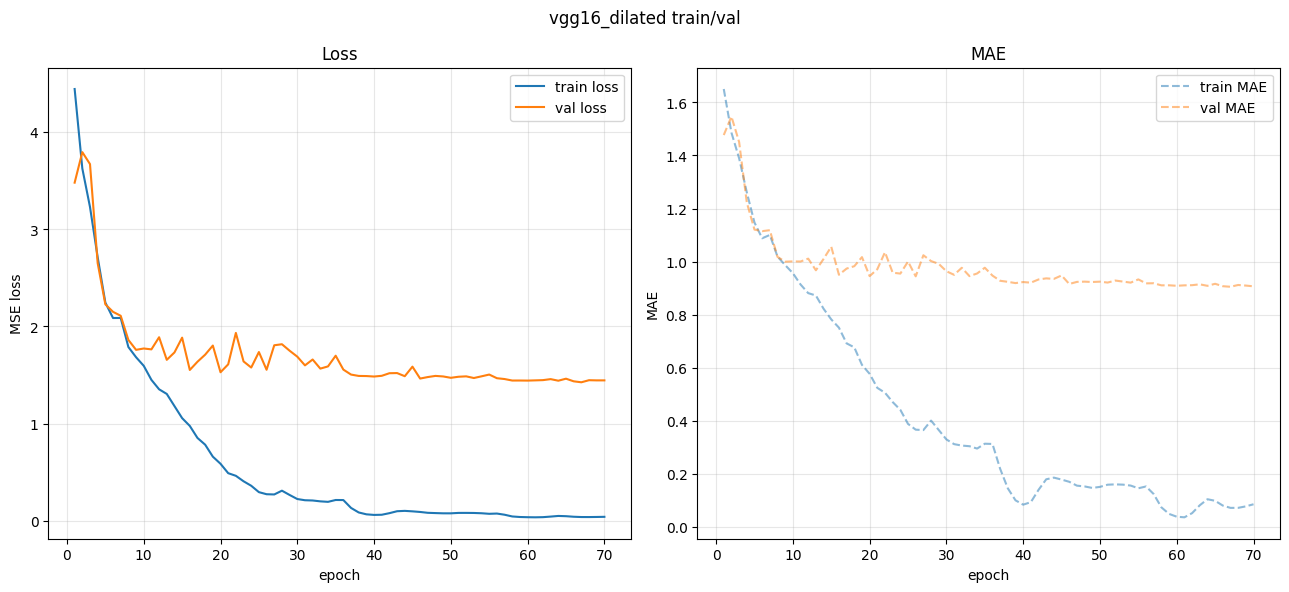

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="glorot_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Dropout

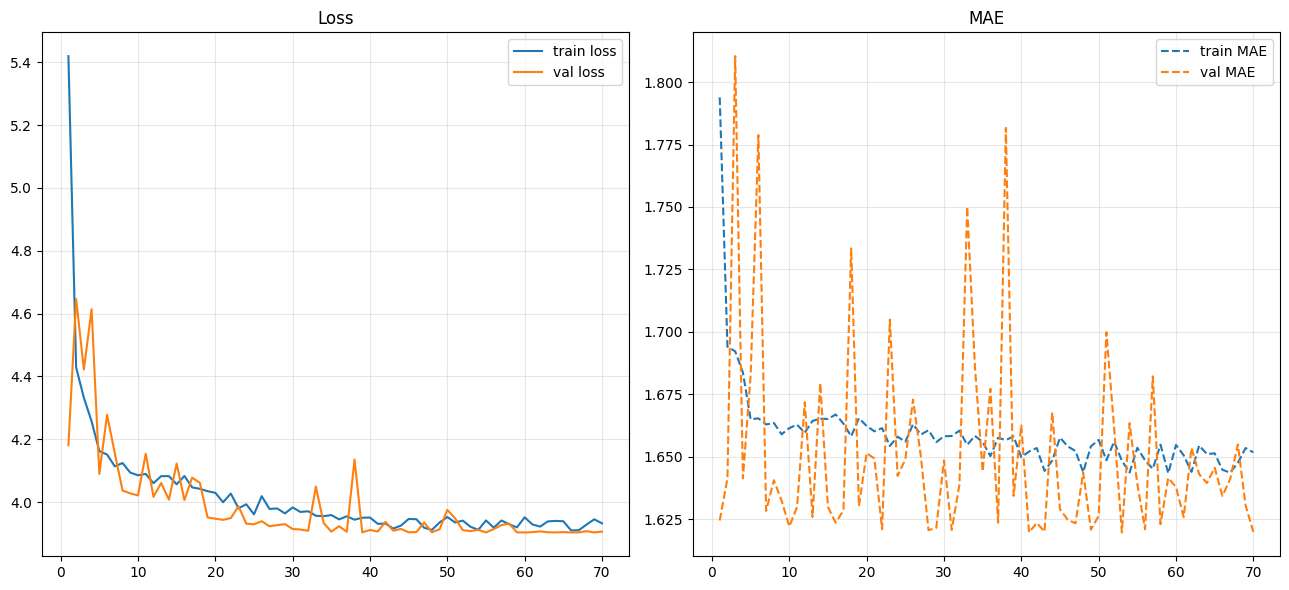

Restoring model weights from the end of the best epoch: 53.


[4.1810150146484375, 4.646490573883057, 4.422243118286133, 4.613945007324219, 4.08932638168335, 4.277833461761475, 4.155206680297852, 4.03658390045166, 4.027588367462158, 4.020902156829834, 4.153848648071289, 4.016606330871582, 4.060609817504883, 4.007431983947754, 4.122498035430908, 4.0059494972229, 4.077755451202393, 4.061007022857666, 3.950829267501831, 3.9469752311706543, 3.943115711212158, 3.94901704788208, 3.986422061920166, 3.9312360286712646, 3.9291419982910156, 3.9389030933380127, 3.922901153564453, 3.9262495040893555, 3.929668664932251, 3.914036273956299, 3.9125068187713623, 3.90840744972229, 4.049075126647949, 3.9333808422088623, 3.905574083328247, 3.922940492630005, 3.9052679538726807, 4.135045051574707, 3.9033291339874268, 3.9111037254333496, 3.905911445617676, 3.936683177947998, 3.908742904663086, 3.91428804397583, 3.903536319732666, 3.9043192863464355, 3.934823751449585, 3.9037516117095947, 3.9132184982299805, 3.9749670028686523, 3.947880983352661, 3.910393476486206, 3.9

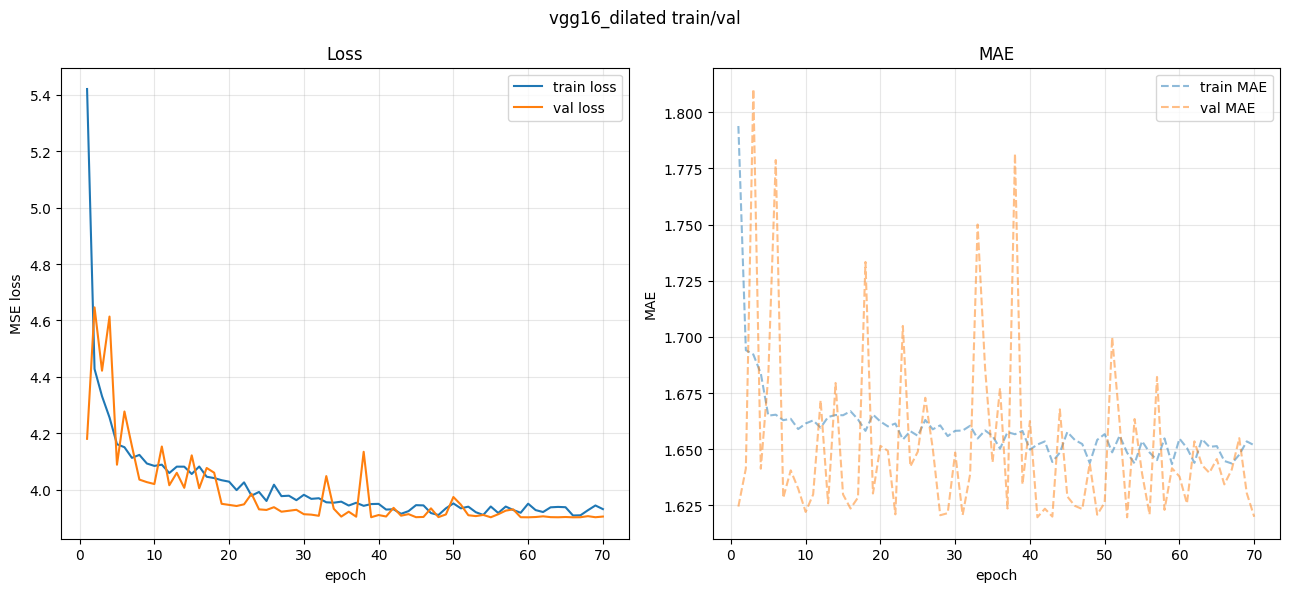

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

Dropout only on dense

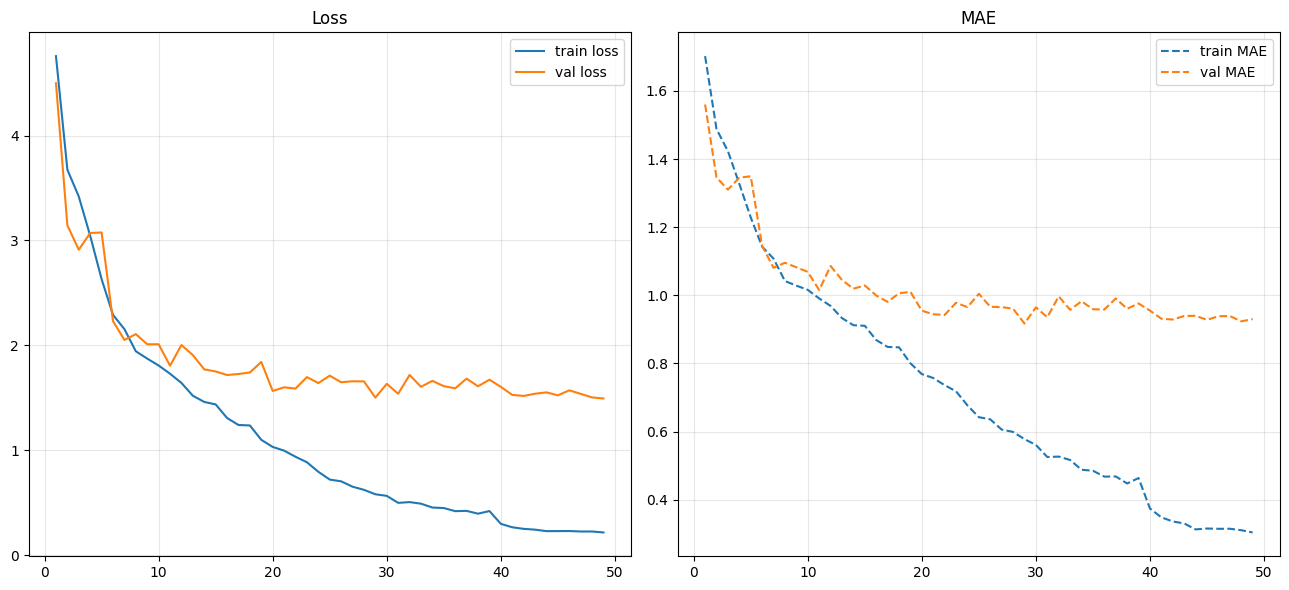

training:  70%|███████    49/70 [18:00<07:34] , loss=0.2175, mse=0.1491


Epoch 49: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 29.


[4.497293949127197, 3.1439061164855957, 2.9116435050964355, 3.071117639541626, 3.075960874557495, 2.231062650680542, 2.0520405769348145, 2.1075143814086914, 2.0108747482299805, 2.010835647583008, 1.8063199520111084, 2.0034241676330566, 1.9075706005096436, 1.771452784538269, 1.7515619993209839, 1.7176491022109985, 1.7272722721099854, 1.7421932220458984, 1.8420605659484863, 1.5658130645751953, 1.6006205081939697, 1.5884873867034912, 1.6979941129684448, 1.6407842636108398, 1.711753249168396, 1.6488394737243652, 1.6580458879470825, 1.6569515466690063, 1.5026230812072754, 1.6334359645843506, 1.5390465259552002, 1.7181981801986694, 1.6054574251174927, 1.6620323657989502, 1.611648678779602, 1.590949535369873, 1.683211326599121, 1.6103588342666626, 1.6732925176620483, 1.6047929525375366, 1.5283877849578857, 1.5184409618377686, 1.5394574403762817, 1.5523983240127563, 1.5240519046783447, 1.5716406106948853, 1.538246750831604, 1.5041602849960327, 1.4940955638885498]
{'loss': 0.21752163767814636, 

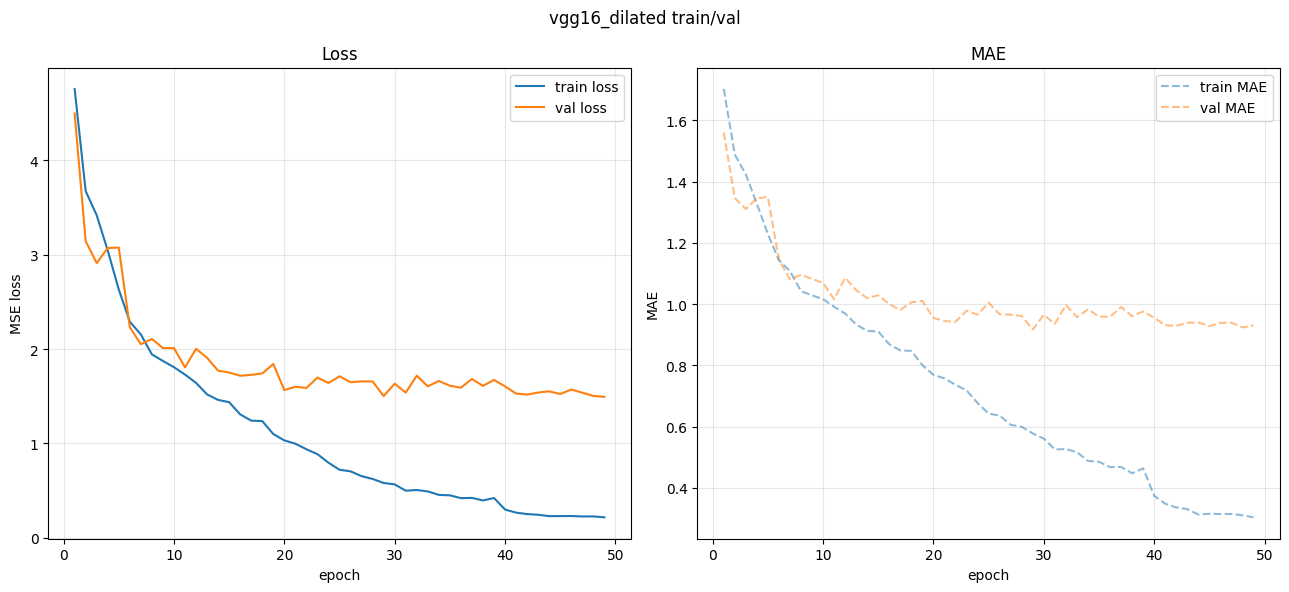

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Xavier/2 initialization

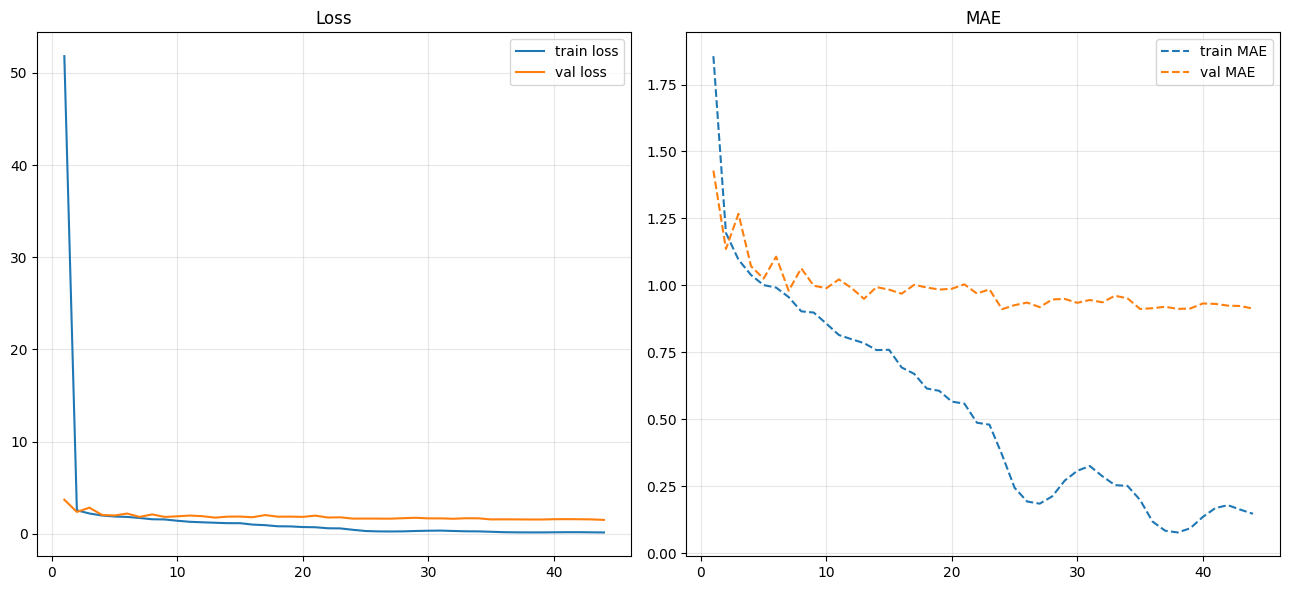

training:  63%|██████▎    44/70 [15:53<09:16] , loss=0.1560, mse=0.0352


Epoch 44: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 24.


[3.7080204486846924, 2.3850038051605225, 2.8472254276275635, 2.054663896560669, 1.9941726922988892, 2.2070212364196777, 1.8419156074523926, 2.1132540702819824, 1.8394651412963867, 1.9071662425994873, 1.9881031513214111, 1.9212599992752075, 1.7663853168487549, 1.8696566820144653, 1.881415605545044, 1.8082480430603027, 2.0442540645599365, 1.8673936128616333, 1.8739993572235107, 1.8446530103683472, 1.9815415143966675, 1.777406930923462, 1.795558214187622, 1.6579663753509521, 1.6636804342269897, 1.660118579864502, 1.6503357887268066, 1.7020716667175293, 1.747876524925232, 1.685006022453308, 1.6833282709121704, 1.6419628858566284, 1.6979867219924927, 1.689997911453247, 1.5699130296707153, 1.5790672302246094, 1.574472427368164, 1.5625966787338257, 1.5587356090545654, 1.5910242795944214, 1.5996886491775513, 1.5893141031265259, 1.5740435123443604, 1.5178427696228027]
{'loss': 0.15595032274723053, 'val_loss': 1.5178427696228027, 'mean_absolute_error': 0.14677341282367706, 'val_mean_absolute_err

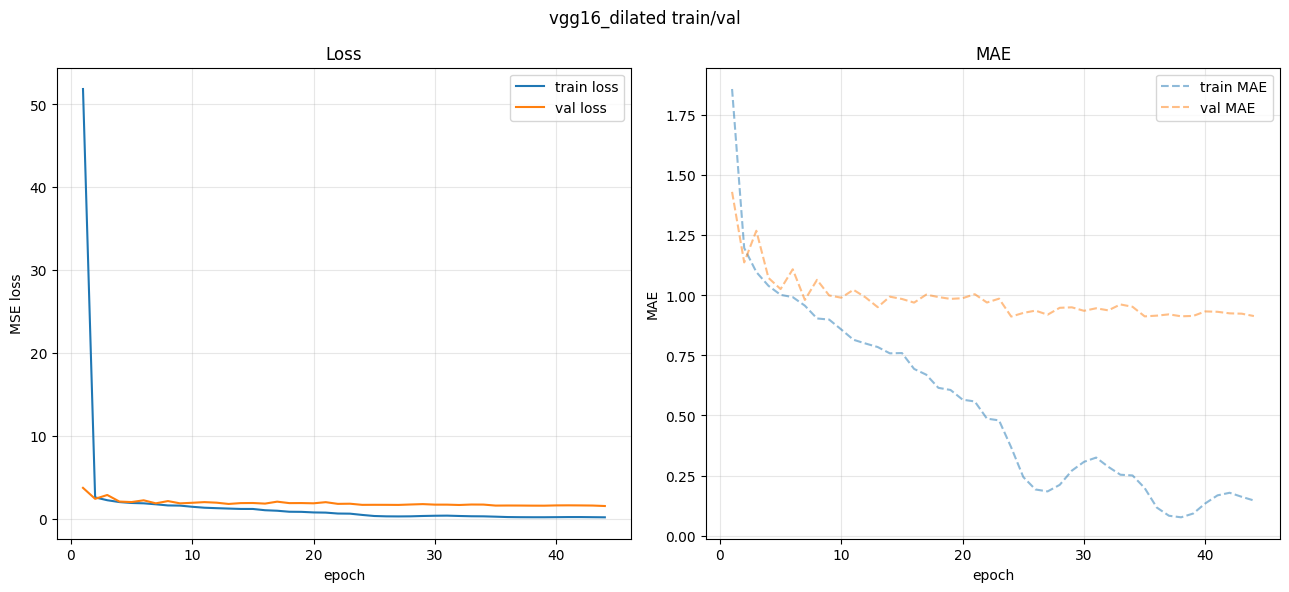

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="he_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

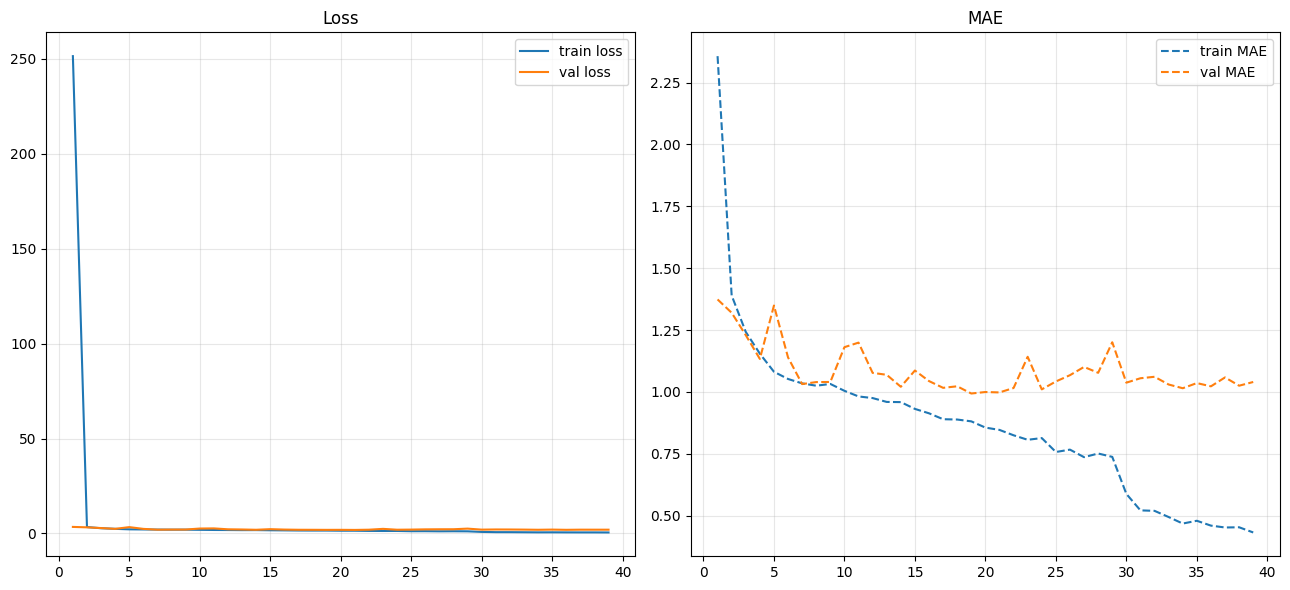

training:  56%|█████▌     39/70 [14:17<11:12] , loss=0.5033, mse=0.2994


Epoch 39: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.


[3.42583966255188, 3.2031829357147217, 2.821016550064087, 2.405019521713257, 3.3187544345855713, 2.3880741596221924, 1.9698880910873413, 2.0248255729675293, 2.0413858890533447, 2.5691258907318115, 2.6446070671081543, 2.167358636856079, 2.069965124130249, 1.9196630716323853, 2.2365615367889404, 2.0261993408203125, 1.9219932556152344, 1.9047737121582031, 1.8724000453948975, 1.8874187469482422, 1.8398196697235107, 1.956781268119812, 2.3977527618408203, 1.9470083713531494, 2.012554883956909, 2.13385272026062, 2.183960199356079, 2.197404384613037, 2.5232009887695312, 1.9948426485061646, 2.079190492630005, 2.060736656188965, 2.006052255630493, 1.9193171262741089, 2.0127599239349365, 1.8952572345733643, 1.9727877378463745, 1.9639770984649658, 1.9619206190109253]
{'loss': 0.5032846927642822, 'val_loss': 1.9619206190109253, 'mean_absolute_error': 0.43232783675193787, 'val_mean_absolute_error': 1.0402356386184692}
[vgg16_dilated] last: loss=0.5033 | val_loss=1.9619 | rMAE=0.4323 | val_rMAE=1.040

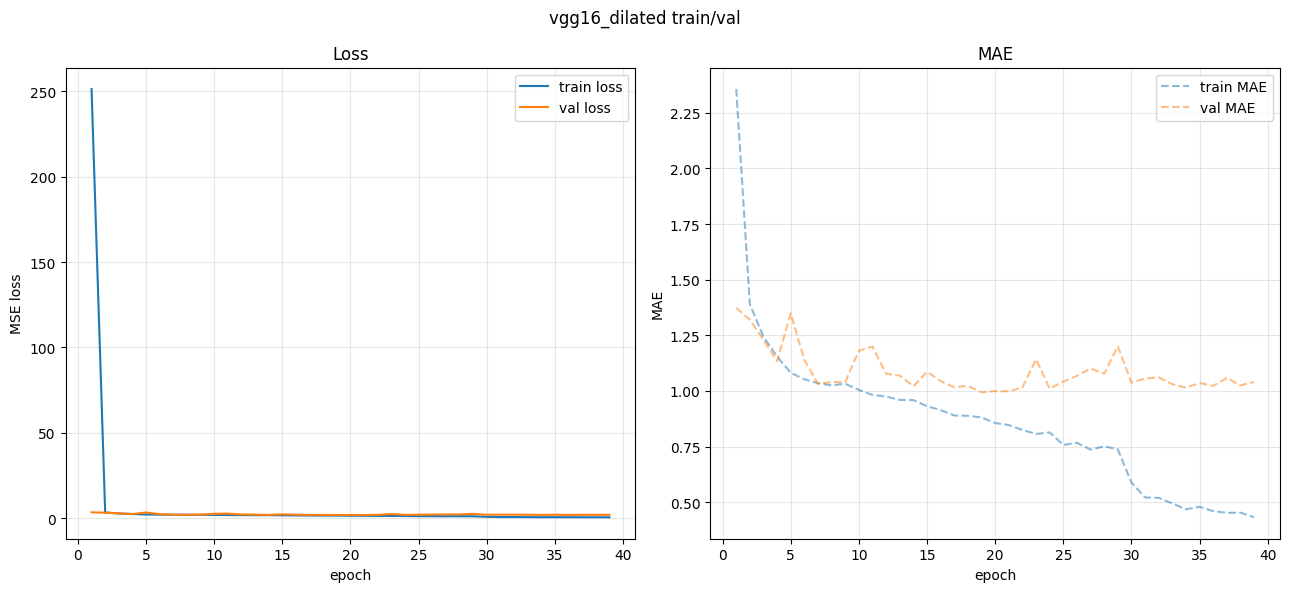

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="he_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

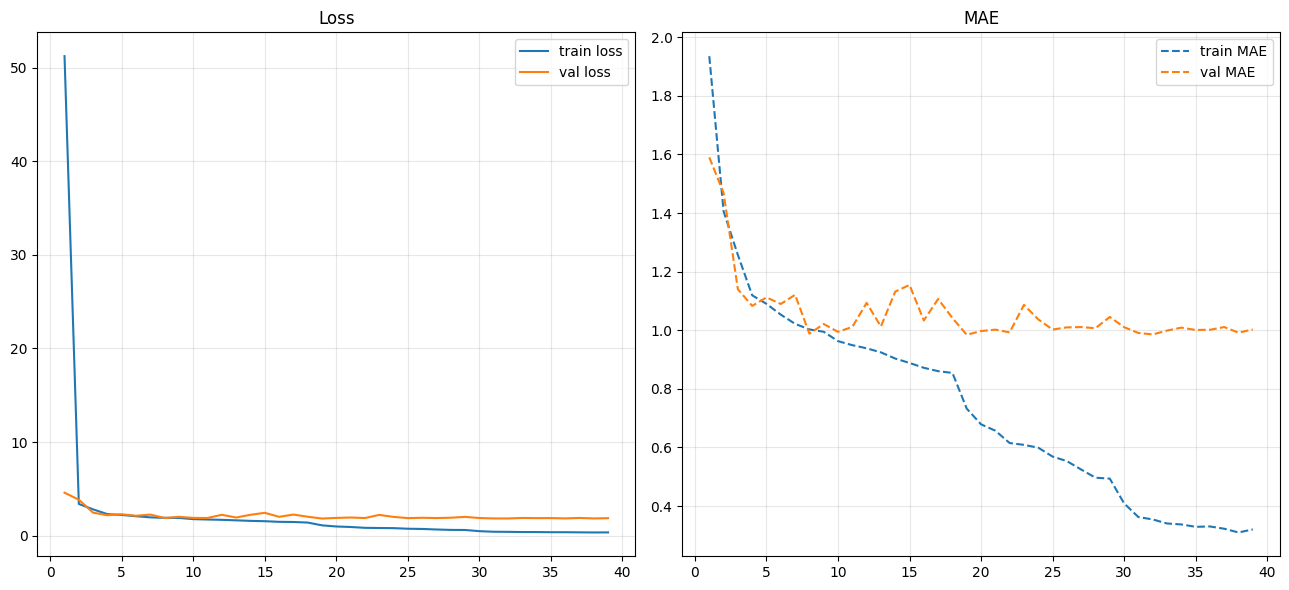

training:  56%|█████▌     39/70 [14:15<11:14] , loss=0.3347, mse=0.1668


Epoch 39: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.


[4.579254627227783, 3.8300132751464844, 2.4431307315826416, 2.1730079650878906, 2.2717084884643555, 2.114284038543701, 2.238283634185791, 1.8752504587173462, 1.9992948770523071, 1.8838574886322021, 1.877209186553955, 2.2161009311676025, 1.9256749153137207, 2.2168893814086914, 2.4294915199279785, 1.9995777606964111, 2.2417702674865723, 2.0111870765686035, 1.8164117336273193, 1.8846405744552612, 1.92518150806427, 1.8703007698059082, 2.20465350151062, 1.9938236474990845, 1.8618192672729492, 1.8980268239974976, 1.8673049211502075, 1.903977632522583, 1.9934896230697632, 1.8720426559448242, 1.8279452323913574, 1.824486494064331, 1.877295970916748, 1.8616366386413574, 1.8663175106048584, 1.830851435661316, 1.8800989389419556, 1.8282992839813232, 1.8553931713104248]
{'loss': 0.3346630036830902, 'val_loss': 1.8553931713104248, 'mean_absolute_error': 0.32025545835494995, 'val_mean_absolute_error': 1.0024749040603638}
[vgg16_dilated] last: loss=0.3347 | val_loss=1.8554 | rMAE=0.3203 | val_rMAE=1.

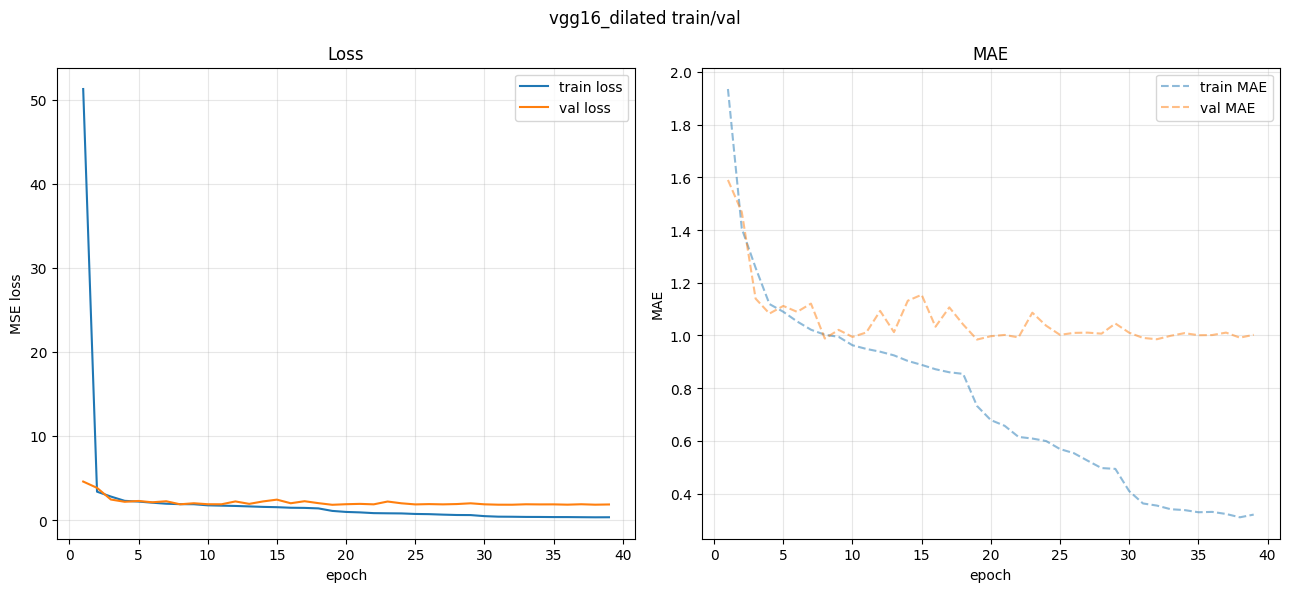

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="he_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Random Initialization

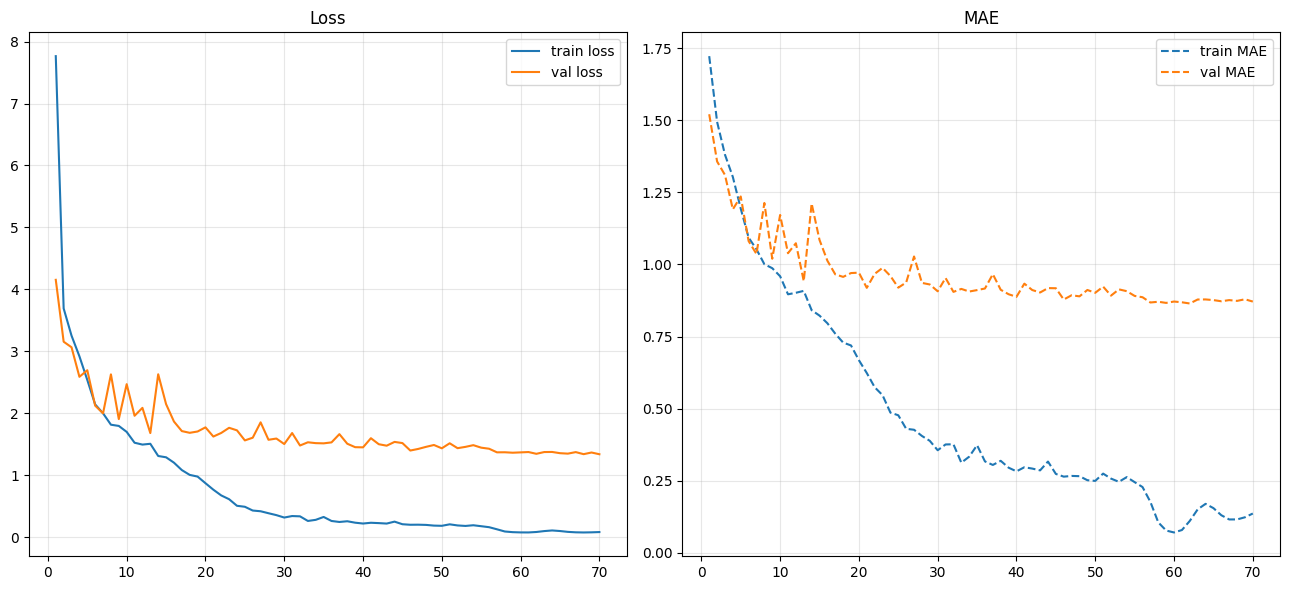

Restoring model weights from the end of the best epoch: 62.


[4.154030799865723, 3.1546785831451416, 3.064796209335327, 2.588144063949585, 2.6941981315612793, 2.122354745864868, 1.998422384262085, 2.627659559249878, 1.9050921201705933, 2.469346284866333, 1.958989143371582, 2.0866646766662598, 1.6794936656951904, 2.629291534423828, 2.1470067501068115, 1.8658512830734253, 1.7116169929504395, 1.6837167739868164, 1.7050578594207764, 1.7718865871429443, 1.6234339475631714, 1.681522011756897, 1.764748215675354, 1.723529577255249, 1.5611534118652344, 1.604729413986206, 1.8530099391937256, 1.5714064836502075, 1.591149926185608, 1.5026321411132812, 1.680213451385498, 1.4787635803222656, 1.5308047533035278, 1.5170170068740845, 1.5136610269546509, 1.529274582862854, 1.662300705909729, 1.5075815916061401, 1.4518847465515137, 1.449175238609314, 1.5965768098831177, 1.4996086359024048, 1.4759762287139893, 1.5369317531585693, 1.5180373191833496, 1.3977088928222656, 1.423384189605713, 1.4573137760162354, 1.4872093200683594, 1.4336849451065063, 1.5148385763168335

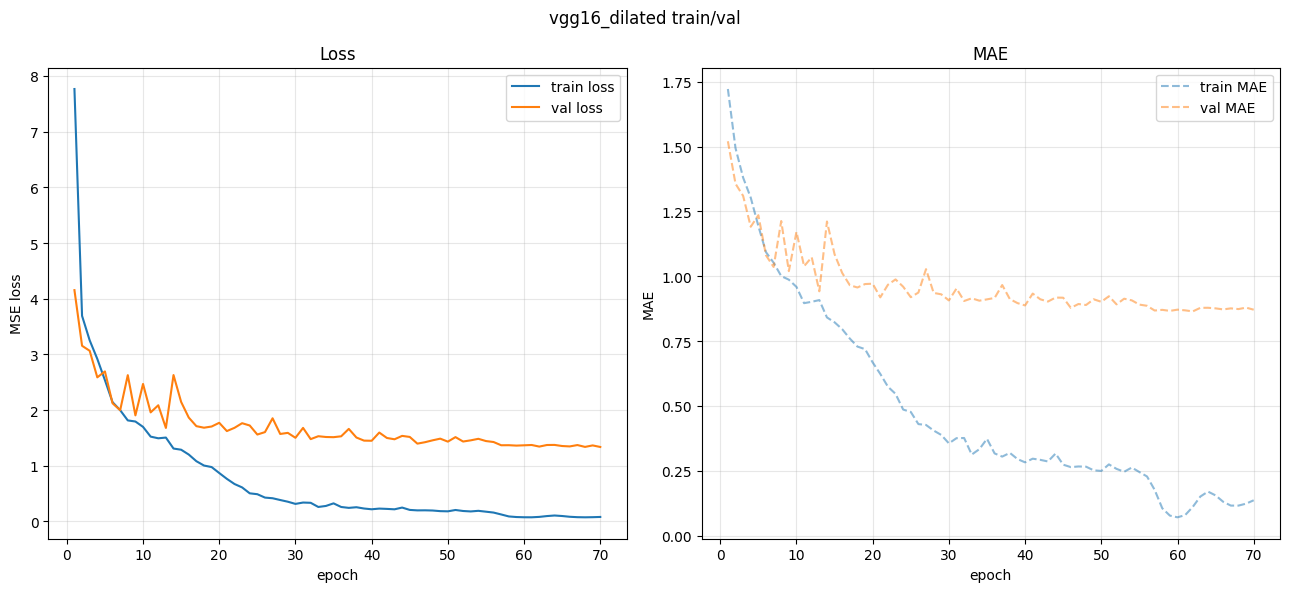

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal"))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

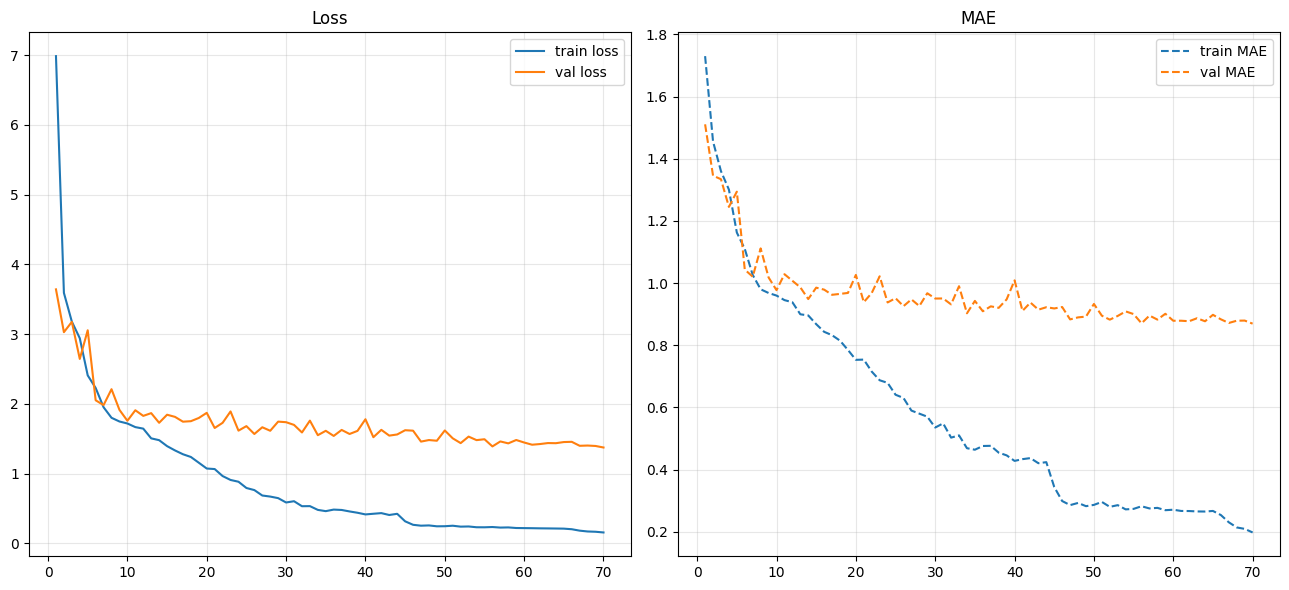

Restoring model weights from the end of the best epoch: 70.


[3.64160418510437, 3.027724266052246, 3.175074338912964, 2.644056797027588, 3.0551602840423584, 2.051274061203003, 1.982060194015503, 2.2099952697753906, 1.9136285781860352, 1.7576065063476562, 1.9081248044967651, 1.8275115489959717, 1.8668584823608398, 1.7284026145935059, 1.8439898490905762, 1.8133844137191772, 1.744379997253418, 1.751367211341858, 1.7974618673324585, 1.8711515665054321, 1.653918743133545, 1.7279762029647827, 1.8910590410232544, 1.6158519983291626, 1.6806217432022095, 1.5679128170013428, 1.6643109321594238, 1.6140434741973877, 1.7452102899551392, 1.736867070198059, 1.6981558799743652, 1.5895193815231323, 1.759446144104004, 1.550684928894043, 1.6134003400802612, 1.5400365591049194, 1.6260735988616943, 1.5679105520248413, 1.6124684810638428, 1.7792394161224365, 1.5218586921691895, 1.6272740364074707, 1.5445563793182373, 1.5609415769577026, 1.6218653917312622, 1.615538477897644, 1.45870041847229, 1.4810158014297485, 1.4710770845413208, 1.6184238195419312, 1.5057371854782

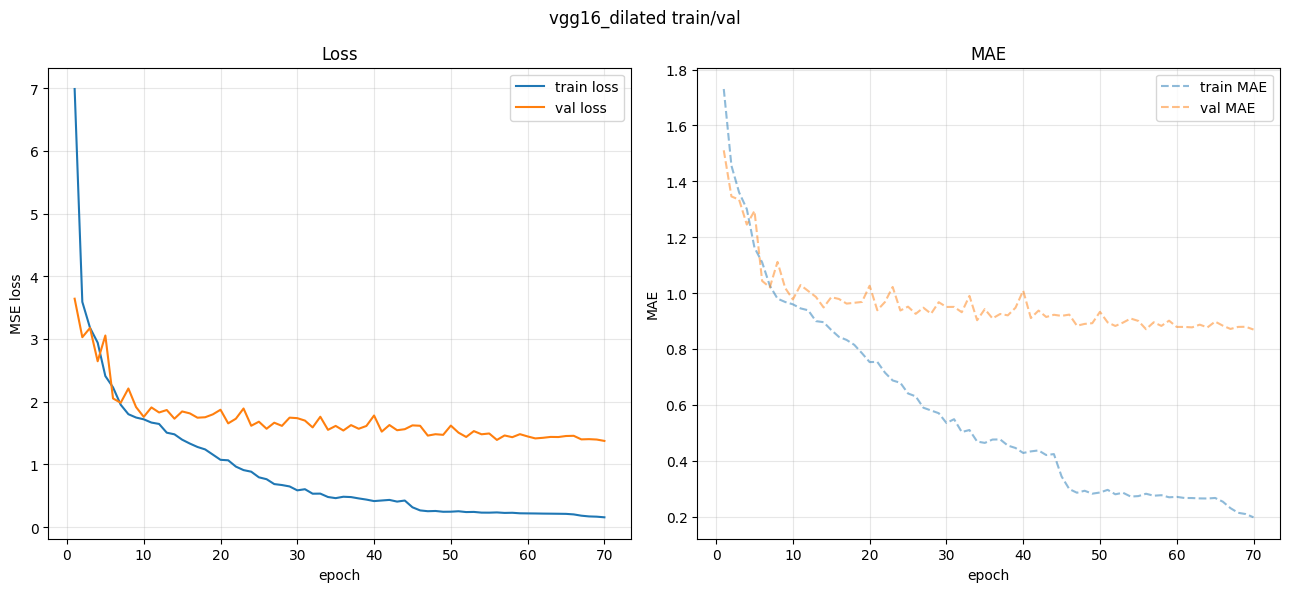

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

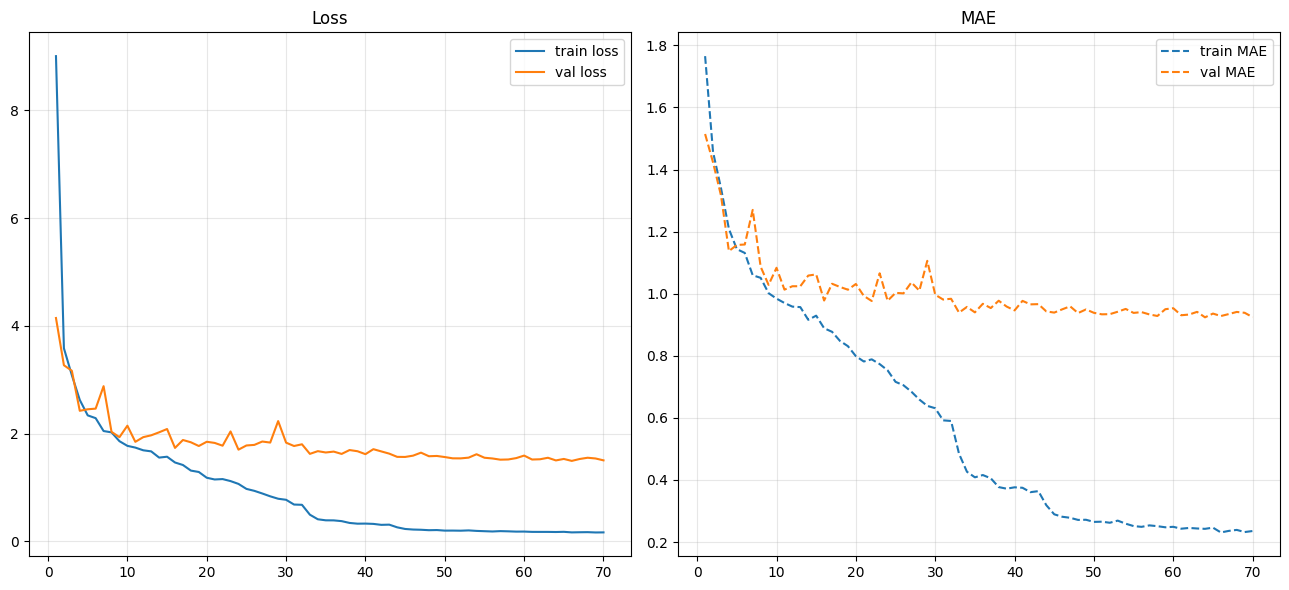

Restoring model weights from the end of the best epoch: 64.


[4.143982410430908, 3.2676892280578613, 3.1648664474487305, 2.4216861724853516, 2.4499495029449463, 2.461991786956787, 2.878697156906128, 2.0308985710144043, 1.9323904514312744, 2.1452109813690186, 1.845715045928955, 1.9327417612075806, 1.966778039932251, 2.022597312927246, 2.0836398601531982, 1.7330423593521118, 1.879797339439392, 1.8375377655029297, 1.768225073814392, 1.8468375205993652, 1.8255833387374878, 1.77402663230896, 2.0385541915893555, 1.700499415397644, 1.7780507802963257, 1.788894772529602, 1.8513484001159668, 1.8319766521453857, 2.230785846710205, 1.8303204774856567, 1.7681888341903687, 1.8000295162200928, 1.6223795413970947, 1.6726467609405518, 1.6480305194854736, 1.6643540859222412, 1.6213425397872925, 1.693242073059082, 1.6711711883544922, 1.6168272495269775, 1.7093842029571533, 1.6677526235580444, 1.6266086101531982, 1.5666605234146118, 1.56515634059906, 1.589156985282898, 1.6449415683746338, 1.5783302783966064, 1.5835908651351929, 1.563210129737854, 1.539482474327087

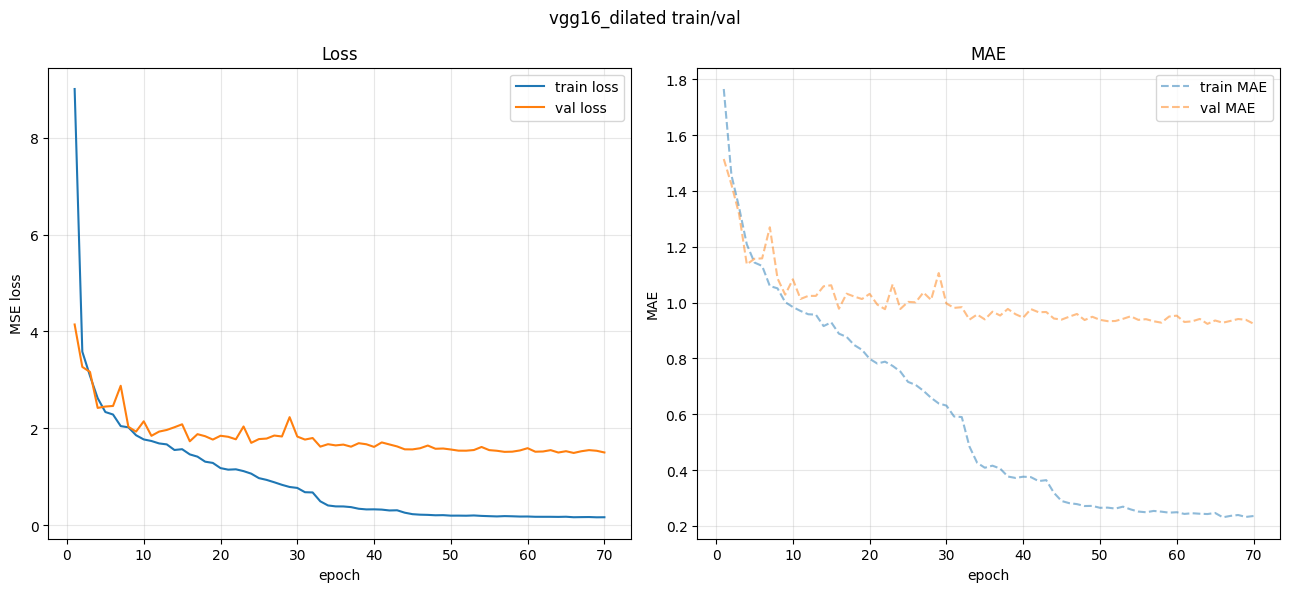

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg

## Different Loss Trials

In [ ]:
def ranking_loss(y_true, y_pred):
    # build pairwise differences within batch
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))
    y_diff  = tf.expand_dims(y_true, 1) - tf.expand_dims(y_true, 0)
    y_pred_diff = tf.expand_dims(y_pred, 1) - tf.expand_dims(y_pred, 0)
    mask = tf.cast(y_diff > 0, tf.float32)
    loss = tf.math.log1p(tf.exp(-y_pred_diff)) * mask   # logistic ranking
    return tf.reduce_mean(loss)

def attractiveness_loss(y_true, y_pred, alpha=1.0, beta=0.2):
    huber = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    rank  = ranking_loss(y_true, y_pred)
    return alpha * huber + beta * rank

In [ ]:
def train_with_val_custom_loss(
        model,
        train_ds_full,
        val_ds_full,
        epochs=100,
        batch_size=32,
        lr=1e-3,
        name="model",
        early_stop=True,
        loss_fn="mse"      # can be "mse", "mae", "huber", "attractiveness"
    ):

    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    # choose loss ---------------------------------------------------------------
    if loss_fn == "mse":
        loss = tf.keras.losses.MeanSquaredError()
    elif loss_fn == "mae":
        loss = tf.keras.losses.MeanAbsoluteError()
    elif loss_fn == "huber":
        loss = tf.keras.losses.Huber(delta=1.0)
    elif loss_fn == "attractiveness":
        # composite regression + ranking
        loss = attractiveness_loss
    else:
        raise ValueError(f"Unknown loss type: {loss_fn}")
    # --------------------------------------------------------------------------

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    for layer in model.layers:
        if hasattr(layer, "kernel_regularizer") and layer.kernel_regularizer:
            print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")

    # callbacks ----------------------------------------------------------------
    cbs = [LivePlot(), SingleBar(), callbacks.TerminateOnNaN()]
    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(
                monitor="val_mean_absolute_error",
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=1,
                mode="min",
            ),
            callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                patience=20,
                restore_best_weights=True,
                verbose=1,
                mode="min",
            ),
        ]
    # --------------------------------------------------------------------------

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs} | loss={loss_fn}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,
        callbacks=cbs,
    ).history

    # summary ------------------------------------------------------------------
    last = {
        "loss": h["loss"][-1],
        "val_loss": h.get("val_loss", [float("nan")])[-1],
        "mean_absolute_error": h.get("mean_absolute_error", [float("nan")])[-1],
        "val_mean_absolute_error": h.get("val_mean_absolute_error", [float("nan")])[-1],
    }
    print(f"[{name}] last: loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"rMAE={last['mean_absolute_error']:.4f} | val_rMAE={last['val_mean_absolute_error']:.4f}")

    plot_train_val_history(h, title=f"{name} train/val")

    return h

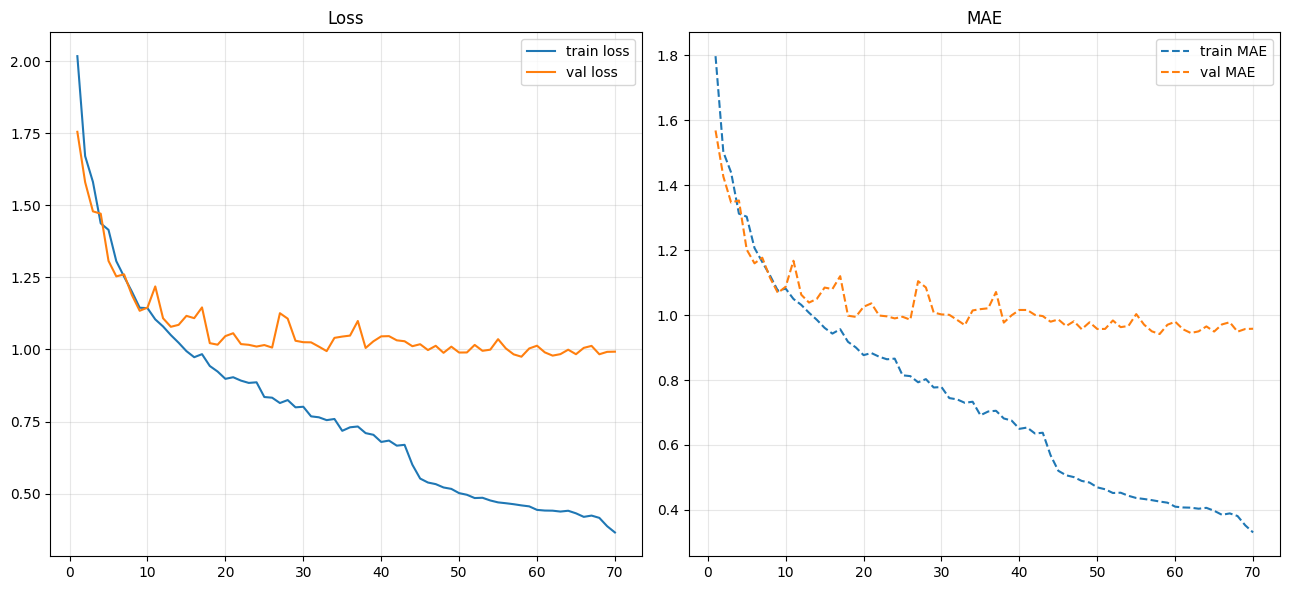

Restoring model weights from the end of the best epoch: 58.


[vgg16_dilated] last: loss=0.3652 | val_loss=0.9923 | rMAE=0.3306 | val_rMAE=0.9578


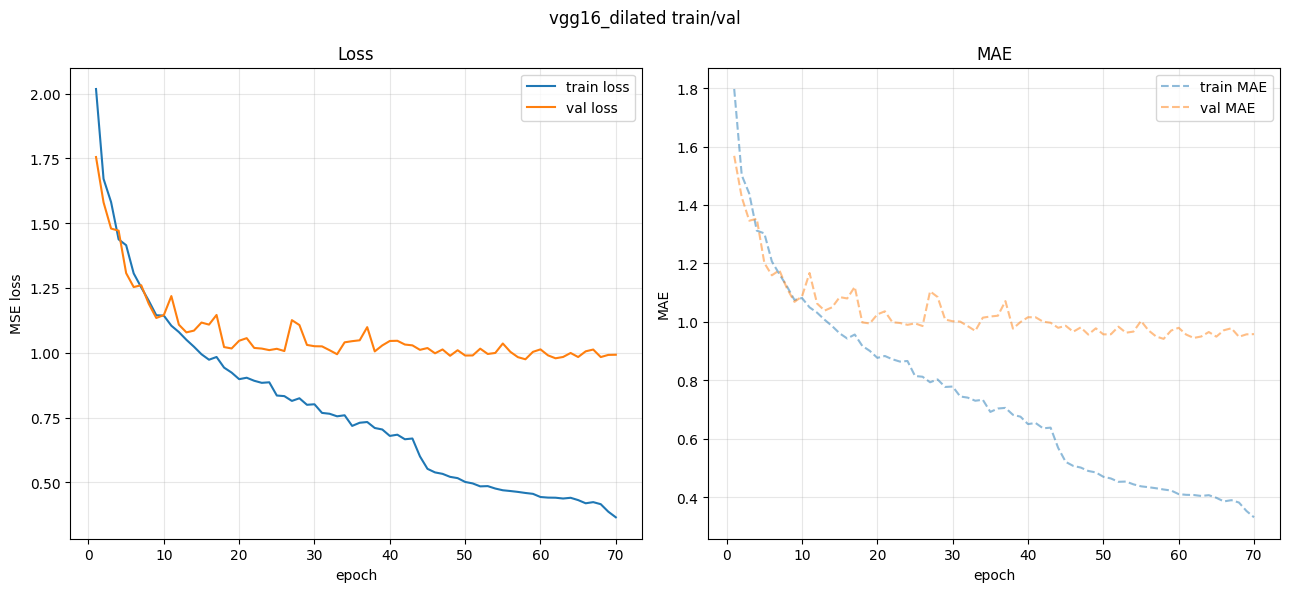

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="mae"
)
del dilated_vgg

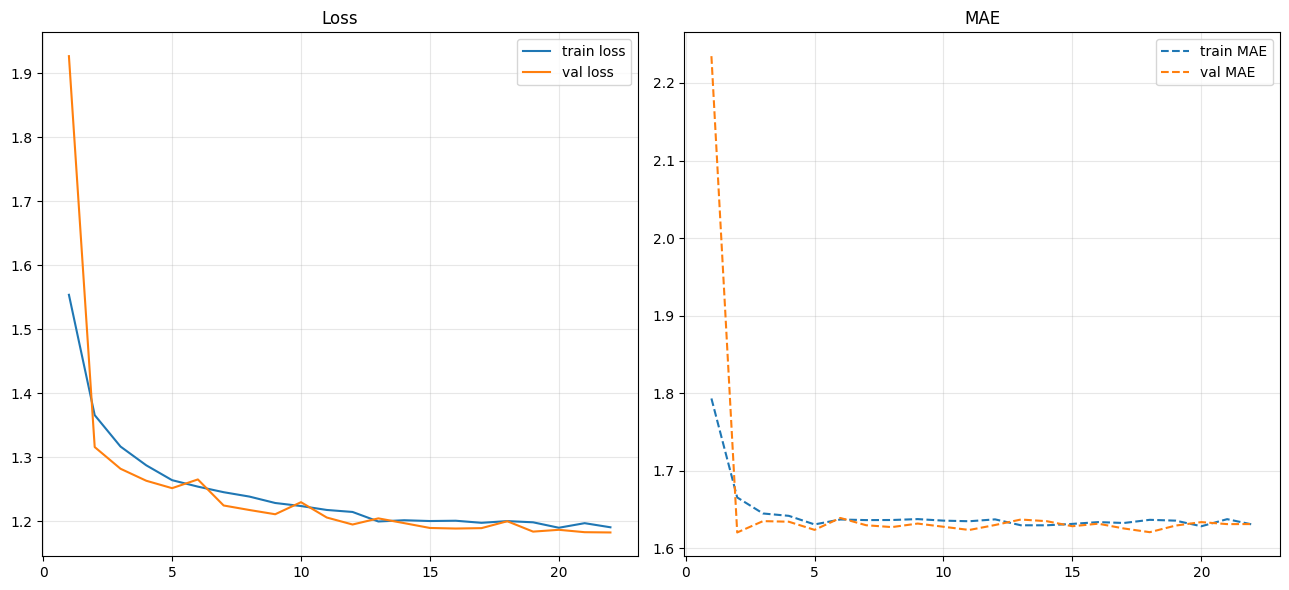

training:  31%|███▏       22/70 [08:01<17:26] , loss=1.1909, mse=4.0887


Epoch 22: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.


[vgg16_dilated] last: loss=1.1909 | val_loss=1.1828 | rMAE=1.6307 | val_rMAE=1.6314


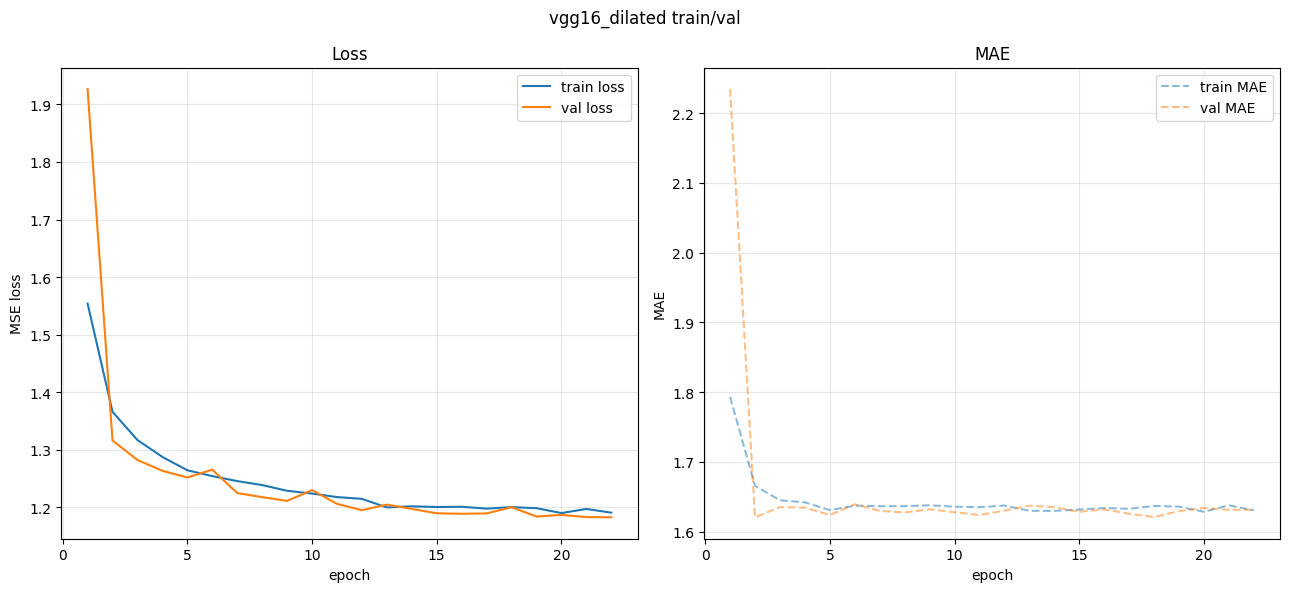

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="huber"
)
del dilated_vgg

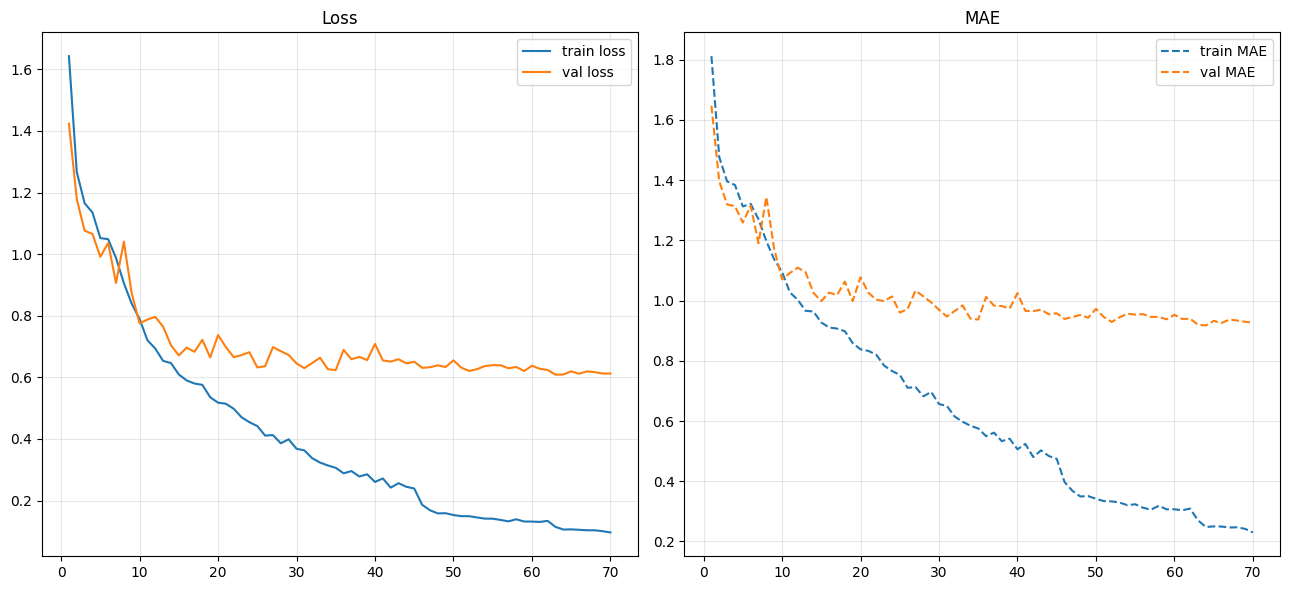

Restoring model weights from the end of the best epoch: 64.


[vgg16_dilated] last: loss=0.0963 | val_loss=0.6124 | rMAE=0.2300 | val_rMAE=0.9268


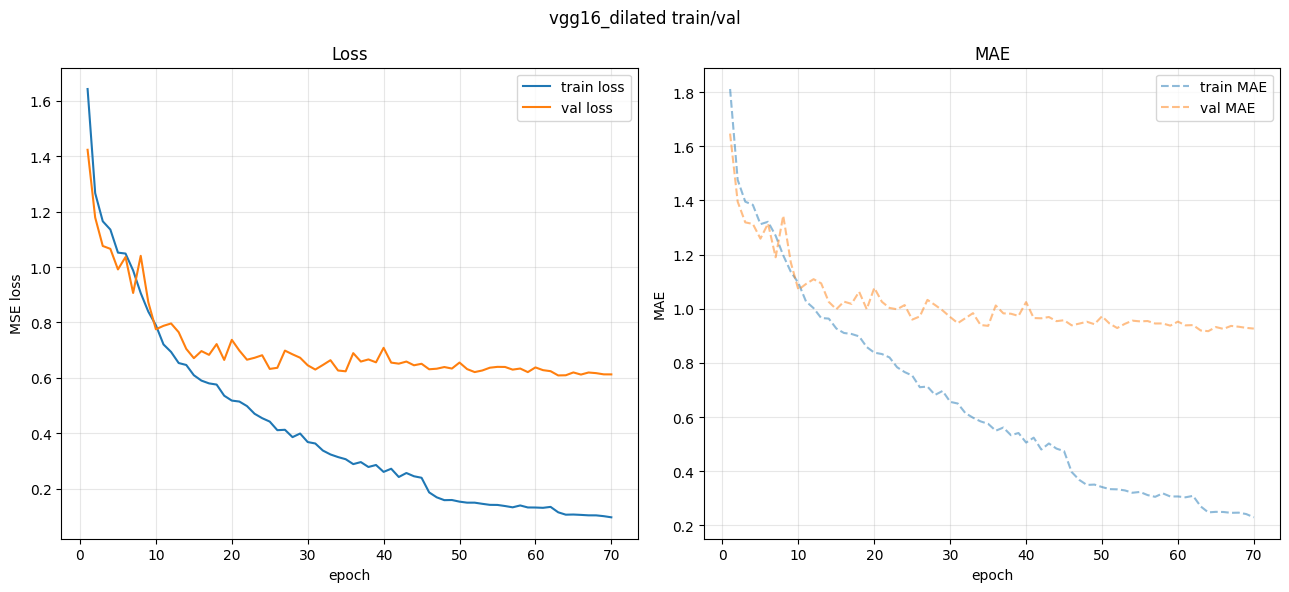

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=False, l2_norm=1e-4, initialization_type="random_normal",dropout_only_dense=False,dropout_rate=0.4))
_ = train_with_val_custom_loss(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True, loss_fn="attractiveness"
)
del dilated_vgg